In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import sqlalchemy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
student_conn_string = "mysql+pymysql://student:p7@vw7MCatmnKjy7@data.engeto.com/data"
alchemy_conn = sqlalchemy.create_engine(student_conn_string)

# Úvodní popis a analýza dat ve vztahu k celkové poptávce

In [2]:
# load data
weather_df = pd.read_sql("select * from edinburgh_weather", alchemy_conn)
bikes_df = pd.read_sql("select * from edinburgh_bikes", alchemy_conn)
bikes_df.head()

index          started_at            ended_at  duration  start_station_id  \
0      0 2018-09-15 08:52:05 2018-09-15 09:11:48      1182               247   
1      1 2018-09-15 09:24:33 2018-09-15 09:41:09       995               259   
2      2 2018-09-15 09:48:54 2018-09-15 10:46:40      3466               262   
3      3 2018-09-16 12:01:36 2018-09-16 12:25:26      1430               255   
4      4 2018-09-16 12:03:43 2018-09-16 12:11:16       452               255   

  start_station_name         start_station_description  \
0   Charlotte Square  North Corner of Charlotte Square   
1   St Andrew Square                 North East corner   
2         Canonmills                      near Tesco's   
3  Kings Buildings 4                          X-Y Cafe   
4  Kings Buildings 4                          X-Y Cafe   

   start_station_latitude  start_station_longitude  end_station_id  \
0               55.952335                -3.207101             259   
1               55.954749                -3.192774             262   
2               55.962804                -3.196284             250   
3               55.922001                -3.176902             254   
4               55.922001                -3.176902             253   

   end_station_name                 end_station_description  \
0  St Andrew Square                       North East corner   
1        Canonmills                            near Tesco's   
2     Victoria Quay  Entrance to Scottish Government Office   
3  Kings Building 3                    Kings Building House   
4  Kings Building 2                      Sanderson Building   

   end_station_latitude  end_station_longitude  
0             55.954728              -3.192653  
1             55.962804              -3.196284  
2             55.977638              -3.174116  
3             55.923479              -3.175385  
4             55.923202              -3.171646

### V žádných sloupcích nechybí data s výjimkou station descriptions, data jsou ve správném data typu:

In [3]:
bikes_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340986 entries, 0 to 340985
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   index                      340986 non-null  int64         
 1   started_at                 340986 non-null  datetime64[ns]
 2   ended_at                   340986 non-null  datetime64[ns]
 3   duration                   340986 non-null  int64         
 4   start_station_id           340986 non-null  int64         
 5   start_station_name         340986 non-null  object        
 6   start_station_description  338612 non-null  object        
 7   start_station_latitude     340986 non-null  float64       
 8   start_station_longitude    340986 non-null  float64       
 9   end_station_id             340986 non-null  int64         
 10  end_station_name           340986 non-null  object        
 11  end_station_description    338426 non-null  object  

### Rozsah dat v čase - datumy a případné chybějící data
Data jsou od 15/09/2018 do 30/10/2020  
U většiny měsíců chybí data z posledního dne, jak u začátku, tak i u konce výpůjčky.  
Asi chyba při tvorbě datové tabulky nebo získávání dat ?

In [4]:
# Dates range and missing dates in data:
start_days = bikes_df["started_at"].astype("datetime64[D]")
end_days = bikes_df["ended_at"].astype("datetime64[D]")
missing_dict = {"Missing Start Dates": pd.date_range(start= start_days.min(), end= start_days.max()).difference(start_days), 
            "Missing End Dates": pd.date_range(start= end_days.min(), end= end_days.max()).difference(end_days)
             }
print("Min Date:", start_days.min())
print("Max Date:", start_days.max())
print("DIFF:", start_days.max()-start_days.min())
print("Chybí údaje z těchto datumů:")
pd.DataFrame({key:pd.Series(value) for key, value in missing_dict.items()})

Min Date: 2018-09-15 00:00:00
Max Date: 2020-10-30 00:00:00
DIFF: 776 days 00:00:00
Chybí údaje z těchto datumů:


Missing Start Dates Missing End Dates
0           2018-10-31        2018-10-31
1           2018-11-30        2018-11-30
2           2018-12-31        2018-12-31
3           2019-01-31        2019-01-31
4           2019-04-30        2019-04-30
5           2019-05-31        2019-05-31
6           2019-06-30        2019-06-30
7           2019-07-31        2019-08-31
8           2019-08-31        2019-09-30
9           2019-09-30        2019-10-31
10          2019-10-31        2019-11-30
11          2019-11-30        2019-12-31
12          2019-12-31        2020-01-31
13          2020-01-31        2020-02-29
14          2020-02-29        2020-03-31
15          2020-03-31        2020-04-30
16          2020-04-30        2020-05-31
17          2020-05-31        2020-06-30
18          2020-06-30        2020-07-31
19          2020-07-31        2020-08-31
20          2020-08-31        2020-09-30
21          2020-09-30               NaT

<b>U "ended_at" chybí stejná data jako "started_at" kromě 31/07/2019, což je ale jen kvůli jediné výpůjčce z 30/7 , která byla vrácena až po půlnoci. Jinak data z 31/7 chybí:</b>

In [5]:
bikes_df[bikes_df["ended_at"] >= "2019-07-31 00:00"].sort_values("ended_at").drop("index",axis=1).head()

started_at            ended_at  duration  start_station_id  \
74084 2019-07-30 22:50:24 2019-07-31 00:00:15      4190               346   
74095 2019-08-01 00:02:06 2019-08-01 00:09:15       429               259   
74096 2019-08-01 00:02:17 2019-08-01 00:11:00       522               259   
74097 2019-08-01 00:11:04 2019-08-01 00:22:01       657               260   
74098 2019-08-01 00:12:41 2019-08-01 00:31:25      1124               247   

      start_station_name                          start_station_description  \
74084   Morningside Road  Corner of Morningside Road & Morningside Park ...   
74095   St Andrew Square                                  North East corner   
74096   St Andrew Square                                  North East corner   
74097    Lauriston Place                               near Chalmers Street   
74098   Charlotte Square                   North Corner of Charlotte Square   

       start_station_latitude  start_station_longitude  end_station_id  \
74084               55.927986                -3.209739             225   
74095               55.954906                -3.192444             261   
74096               55.954906                -3.192444             358   
74097               55.944772                -3.197266            1025   
74098               55.952335                -3.207101             346   

       end_station_name                            end_station_description  \
74084    Waverley Court                        On Waverley Court forecourt   
74095   Brunswick Place              Junction Brunswick Street and Elm Row   
74096        Leith Walk                 Leith Walk opposite Dalmeny Street   
74097    Dundee Terrace                                                      
74098  Morningside Road  Corner of Morningside Road & Morningside Park ...   

       end_station_latitude  end_station_longitude  
74084             55.951734              -3.184179  
74095             55.960930              -3.181005  
74096             55.965040              -3.176686  
74097             55.939710              -3.220589  
74098             55.927986              -3.209739

### Popisná statistika "duration"
Dobra trvání půjčky převedena na minuty.  
Data mají široký rozptyl (STD), více jsem pak zjistil po seskupení dat za den i zobrazení průběhu půjček v čase.  
Také maximum je podezřele vysoké, což jsem si pak všiml více až při analýze poptávky. Také to, že 75% dat je pod 42 minut, naznačuje nepřirozeně vysoké odlehlé hodnoty. (viz dále)

In [6]:
bikes_df["duration"].apply(lambda x: x/60).describe()

count    340986.000000
mean         34.354108
std         145.061465
min           1.016667
25%          10.333333
50%          19.116667
75%          41.866667
max       22884.050000
Name: duration, dtype: float64

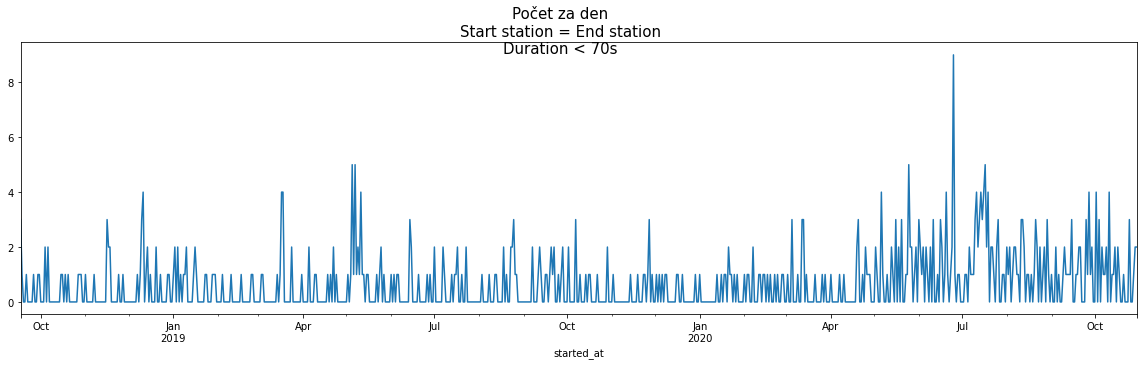

In [7]:
# testing error bias - podezřelé výpujčky na velmi krátkou dobu s vrácením na stejné stanici, je jich minimum
# a jsou rozložené v čase obdobně jako ostatní půjčky - nebudu vylučovat z analýzy
bikes_df.query("duration < 70 & start_station_id == end_station_id").resample("D", on="started_at").count()[["duration"]].plot(figsize=(20,5), legend = None)
plt.gcf().suptitle("Počet za den\nStart station = End station\nDuration < 70s",fontsize=15);

### Pro analýzu poptávky, jsem seskupil data za den a chybějící dny nahradil průměrem ze dnů před a po.

In [8]:
# fill days without data and count per day and sum durations per day in minutes
bikes_days_df = bikes_df.set_index("started_at").resample("D").agg({"duration": [lambda x: sum(x)/60,"count"]}).replace(0, np.nan)[["duration"]].interpolate()["duration"].rename(columns={"<lambda_0>": "sum (min)"})
bikes_days_df["average_duration"] = bikes_days_df["sum (min)"] / bikes_days_df["count"]
bikes_days_df

sum (min)  count  average_duration
started_at                                       
2018-09-15     94.050000    3.0         31.350000
2018-09-16    107.650000   10.0         10.765000
2018-09-17  10503.000000  403.0         26.062035
2018-09-18   3738.850000  126.0         29.673413
2018-09-19   2890.450000   77.0         37.538312
...                  ...    ...               ...
2020-10-26  13628.900000  560.0         24.337321
2020-10-27   8390.900000  437.0         19.201144
2020-10-28  11628.766667  559.0         20.802803
2020-10-29   9897.783333  478.0         20.706660
2020-10-30  18625.200000  770.0         24.188571

[777 rows x 3 columns]

In [9]:
bikes_days_df.describe()

sum (min)        count  average_duration
count     777.000000   777.000000        777.000000
mean    15518.078507   451.797297         32.323486
std     16286.638516   341.287345         19.657251
min        94.050000     3.000000         10.765000
25%      5320.833333   197.000000         20.931807
50%      9565.600000   364.000000         27.638690
75%     18935.416667   576.000000         37.166908
max    113862.166667  2428.000000        287.633021

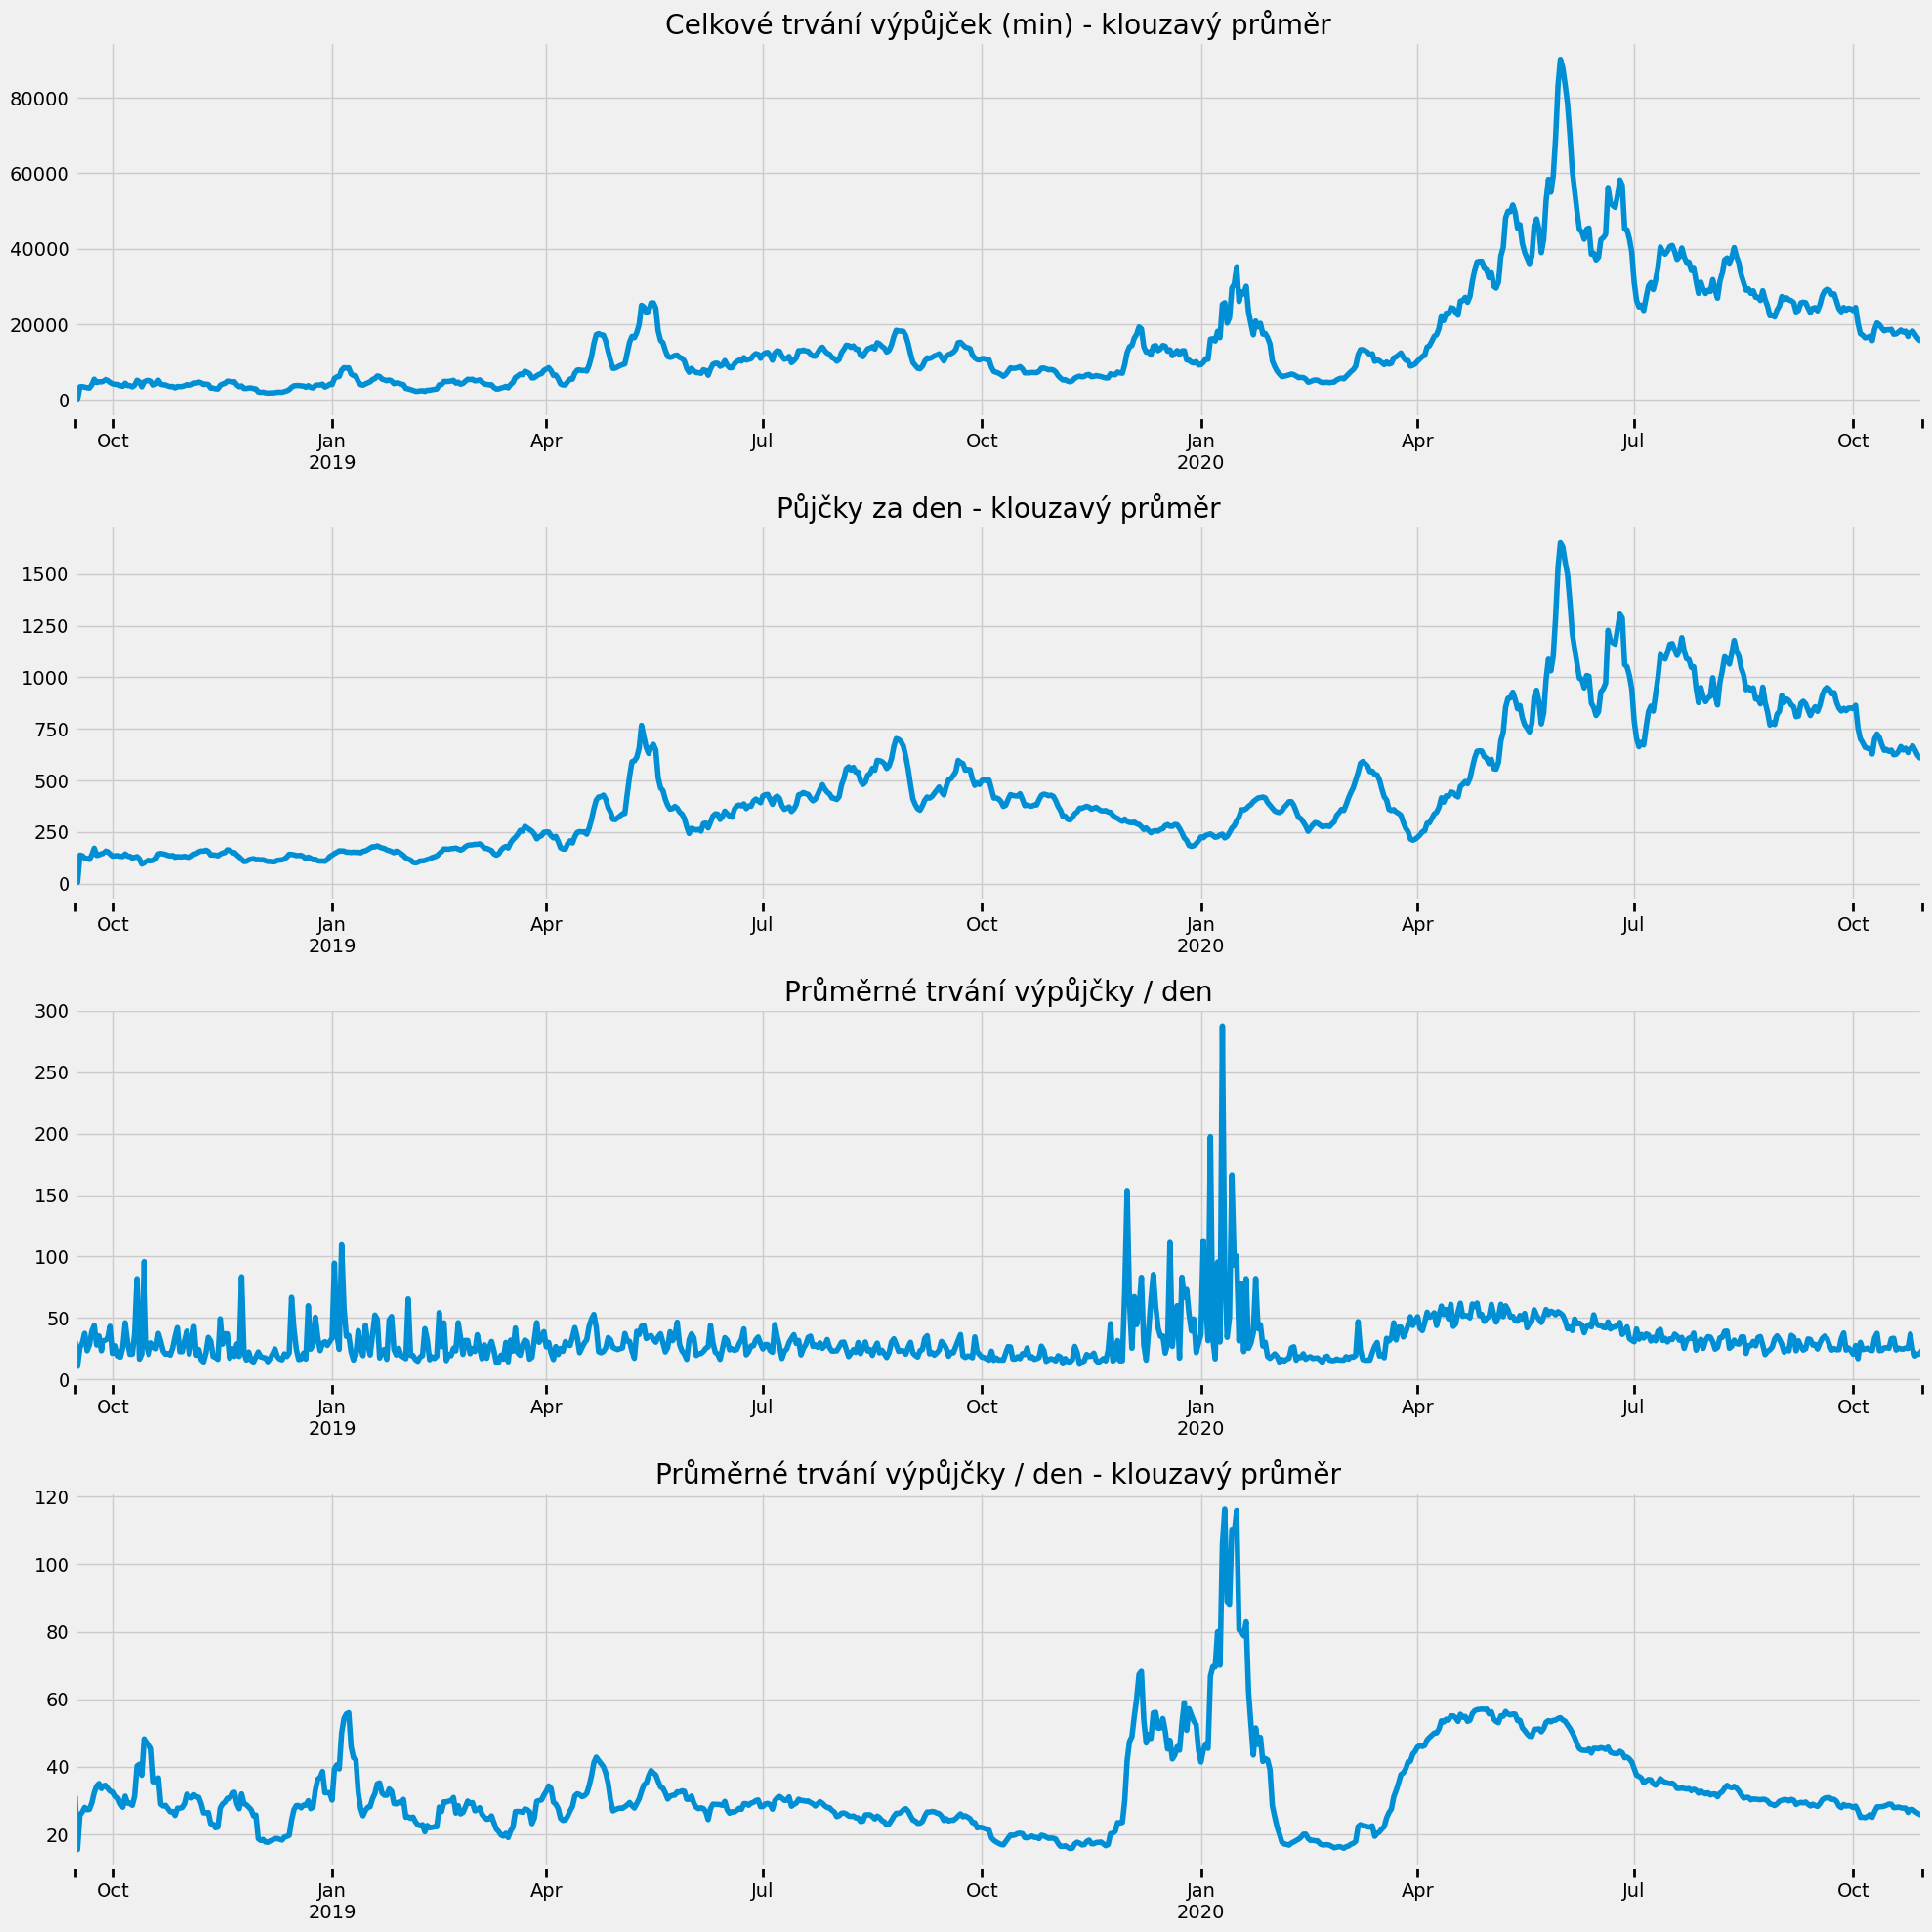

In [10]:
# plots all days

# create simple moving average over 7 days
bikes_days_df["SMA_7_dur"] = bikes_days_df["sum (min)"].rolling(7, min_periods=1).mean()
bikes_days_df["SMA_7_count"] = bikes_days_df["count"].rolling(7, min_periods=1).mean()
bikes_days_df["average_duration2"] = bikes_days_df["SMA_7_dur"] / bikes_days_df["SMA_7_count"] 

colors = ["green", "red", "purple", "blue"]
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,20))



bikes_days_df["SMA_7_dur"].plot(ax=ax1, title= "Celkové trvání výpůjček (min) - klouzavý průměr")
bikes_days_df["SMA_7_count"].plot(ax=ax2, title="Půjčky za den - klouzavý průměr")
bikes_days_df["average_duration"].plot(ax=ax3, title="Průměrné trvání výpůjčky / den")
bikes_days_df["average_duration2"].plot(ax=ax4, title="Průměrné trvání výpůjčky / den - klouzavý průměr")
for ax in [ax1,ax2,ax3,ax4]:
    ax.set(xlabel="")
    ax.tick_params(axis="x",length=8,width=2)
    
fig.tight_layout()

plt.show()

## Prozkoumání podivných čísel z období přelomu roku 2019/2020

#### Zjištění:  
Počty výpůjček cca stagnují v určitém malém rozmezí hodnot, ale doba vypůjčení stoupá některé dny k nesmyslným vysokým číslům,  
která se při použití klouzavého průměru na předchozím grafu částečně zmírní

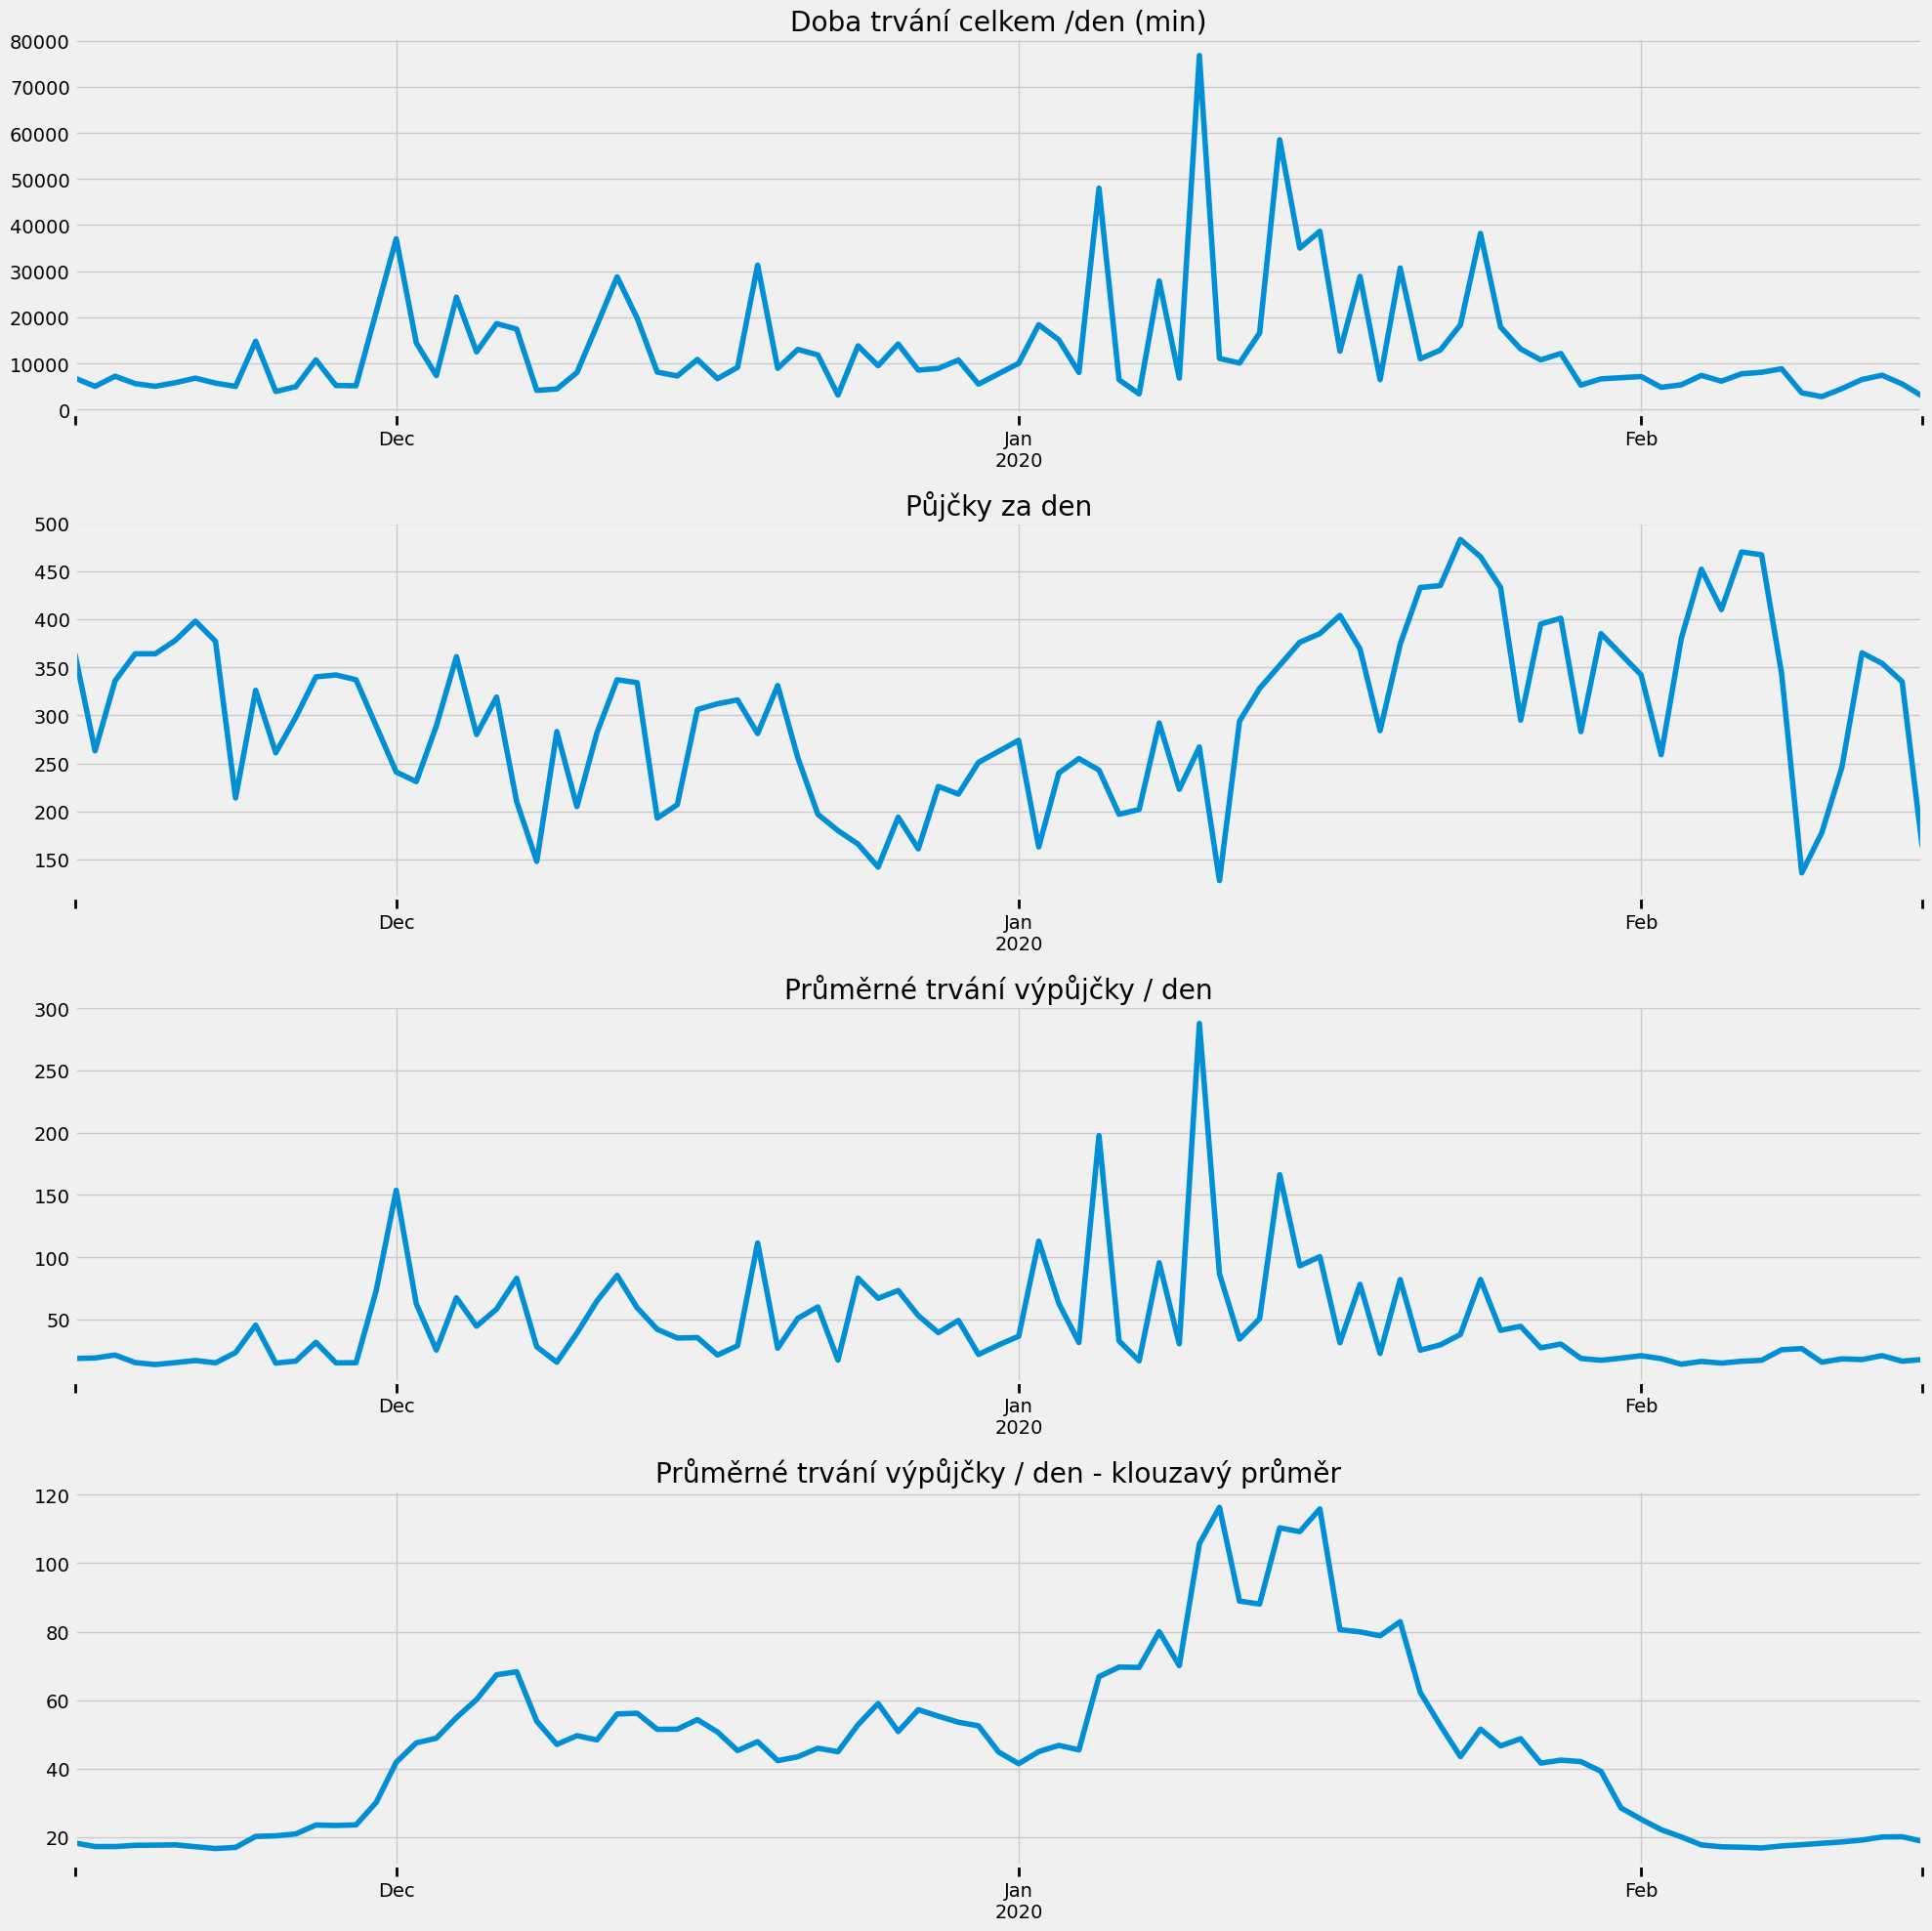

In [11]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,20))

bikes_days_df.loc["2019-11-15":"2020-02-15","sum (min)"].plot(ax=ax1, title= "Doba trvání celkem /den (min)")
bikes_days_df.loc["2019-11-15":"2020-02-15","count"].plot(ax=ax2, title="Půjčky za den")
bikes_days_df.loc["2019-11-15":"2020-02-15","average_duration"].plot(ax=ax3, title="Průměrné trvání výpůjčky / den")
bikes_days_df.loc["2019-11-15":"2020-02-15","average_duration2"].plot(ax=ax4, title="Průměrné trvání výpůjčky / den - klouzavý průměr")
for ax in [ax1,ax2,ax3,ax4]:
    ax.set(xlabel="")
    ax.tick_params(axis="x",length=8,width=2)
    
fig.tight_layout()

plt.show()


In [12]:
bikes_df.set_index("started_at").query("duration > 27000").sort_values(by="duration")
# identifikace outlier vyskoých hodnot cca jako: průměr+ 3*STD = 2061+3*8704 = 27000 s = cca 7 hod

index            ended_at  duration  start_station_id  \
started_at                                                                   
2019-05-02 12:11:50    505 2019-05-02 19:45:21     27211               820   
2020-01-03 17:44:43    606 2020-01-04 01:18:46     27242               265   
2019-04-05 10:59:20    816 2019-04-05 18:33:34     27254               346   
2019-07-02 00:07:41    436 2019-07-02 07:47:13     27572               183   
2019-04-22 12:14:52   5650 2019-04-22 19:58:40     27828               820   
...                    ...                 ...       ...               ...   
2020-01-16 13:23:43   4034 2020-01-29 13:42:50   1124346              1025   
2019-12-01 11:18:47     69 2019-12-15 02:45:58   1178830               876   
2020-01-08 14:00:39   1707 2020-01-23 14:29:08   1297708              1098   
2020-01-14 07:58:47   3129 2020-01-29 18:29:00   1333812              1747   
2020-01-10 17:45:45   2300 2020-01-26 15:09:48   1373043              1017   

                     start_station_name  \
started_at                                
2019-05-02 12:11:50         Newkirkgate   
2020-01-03 17:44:43        Meadows East   
2019-04-05 10:59:20    Morningside Road   
2019-07-02 00:07:41     Waverley Bridge   
2019-04-22 12:14:52         Newkirkgate   
...                                 ...   
2020-01-16 13:23:43      Dundee Terrace   
2019-12-01 11:18:47         Murrayfield   
2020-01-08 14:00:39  Marchmont Crescent   
2020-01-14 07:58:47   Corstorphine Road   
2020-01-10 17:45:45     Crichton Street   

                                             start_station_description  \
started_at                                                               
2019-05-02 12:11:50  19 point docking station beside queen victoria...   
2020-01-03 17:44:43              Between Melville Terrace and Sciennes   
2019-04-05 10:59:20  Corner of Morningside Road & Morningside Park ...   
2019-07-02 00:07:41                     near the top of the South ramp   
2019-04-22 12:14:52  19 point docking station beside queen victoria...   
...                                                                ...   
2020-01-16 13:23:43           Corner of Dundee Street & Dundee Terrace   
2019-12-01 11:18:47                                Riversdale Crescent   
2020-01-08 14:00:39                           Corner of Marchmont Road   
2020-01-14 07:58:47   Outside Silvan House, Forestry and Land Scotland   
2020-01-10 17:45:45                                 East end of street   

                     start_station_latitude  start_station_longitude  \
started_at                                                             
2019-05-02 12:11:50               55.970704                -3.171624   
2020-01-03 17:44:43               55.939809                -3.182739   
2019-04-05 10:59:20               55.927986                -3.209739   
2019-07-02 00:07:41               55.951344                -3.191421   
2019-04-22 12:14:52               55.970704                -3.171624   
...                                     ...                      ...   
2020-01-16 13:23:43               55.939710                -3.220589   
2019-12-01 11:18:47               55.944767                -3.243688   
2020-01-08 14:00:39               55.936432                -3.194150   
2020-01-14 07:58:47               55.941670                -3.271524   
2020-01-10 17:45:45               55.944784                -3.186906   

                     end_station_id     end_station_name  \
started_at                                                 
2019-05-02 12:11:50             285       Ocean Terminal   
2020-01-03 17:44:43            1025       Dundee Terrace   
2019-04-05 10:59:20             346     Morningside Road   
2019-07-02 00:07:41             648      Western General   
2019-04-22 12:14:52             820          Newkirkgate   
...                             ...                  ...   
2020-01-16 13:23:43             183      Waverley Bridge   
2019-1

## Předělání tabulky a grafů bez řádků s velmi vysokou dobou trvání
<b>I po vyloučení odlehlých hodnot, je vidět velké SD odchylky, i když grafy průběhu výpůjček v čase vypadají lépe. Vysoká SD je daná asi výrazným nárůstem výpůjček na jaře 2020. Ale data z roku 2020 nejsou kompletní a je jich výrazně méně než před tímto datem. Jak pak je dále vidět u analýzy počasí, dalo by se asi brát data zvlášť před a po jaru 2020...

In [13]:
# Předělání tabulky bez odlehlých hodnot řádků s velmi vysokou dobou trvání
# Za odlehlou hodnotu jsem vzal cca >3*STD - vyloučí se cca 500 řádek z 340000

bikes_days_df = bikes_df.set_index("started_at").query("duration < 27000").resample("D").agg({"duration": [lambda x: sum(x)/60,"count"]}).replace(0, np.nan)[["duration"]].interpolate()["duration"].rename(columns={"<lambda_0>": "sum (min)"})
bikes_days_df["average_duration"] = bikes_days_df["sum (min)"] / bikes_days_df["count"]
bikes_days_df.describe()

sum (min)        count  average_duration
count     777.000000   777.000000        777.000000
mean    14154.032239   451.180180         27.171717
std     16098.678066   341.445534         10.611126
min        94.050000     3.000000         10.765000
25%      4458.483333   195.000000         19.130545
50%      7845.633333   364.000000         24.528907
75%     17379.400000   575.000000         32.167030
max    113862.166667  2428.000000         62.250597

### Předělání grafů s klouzavým průměrem - vlna z období přelomu roku 2020 zmizí

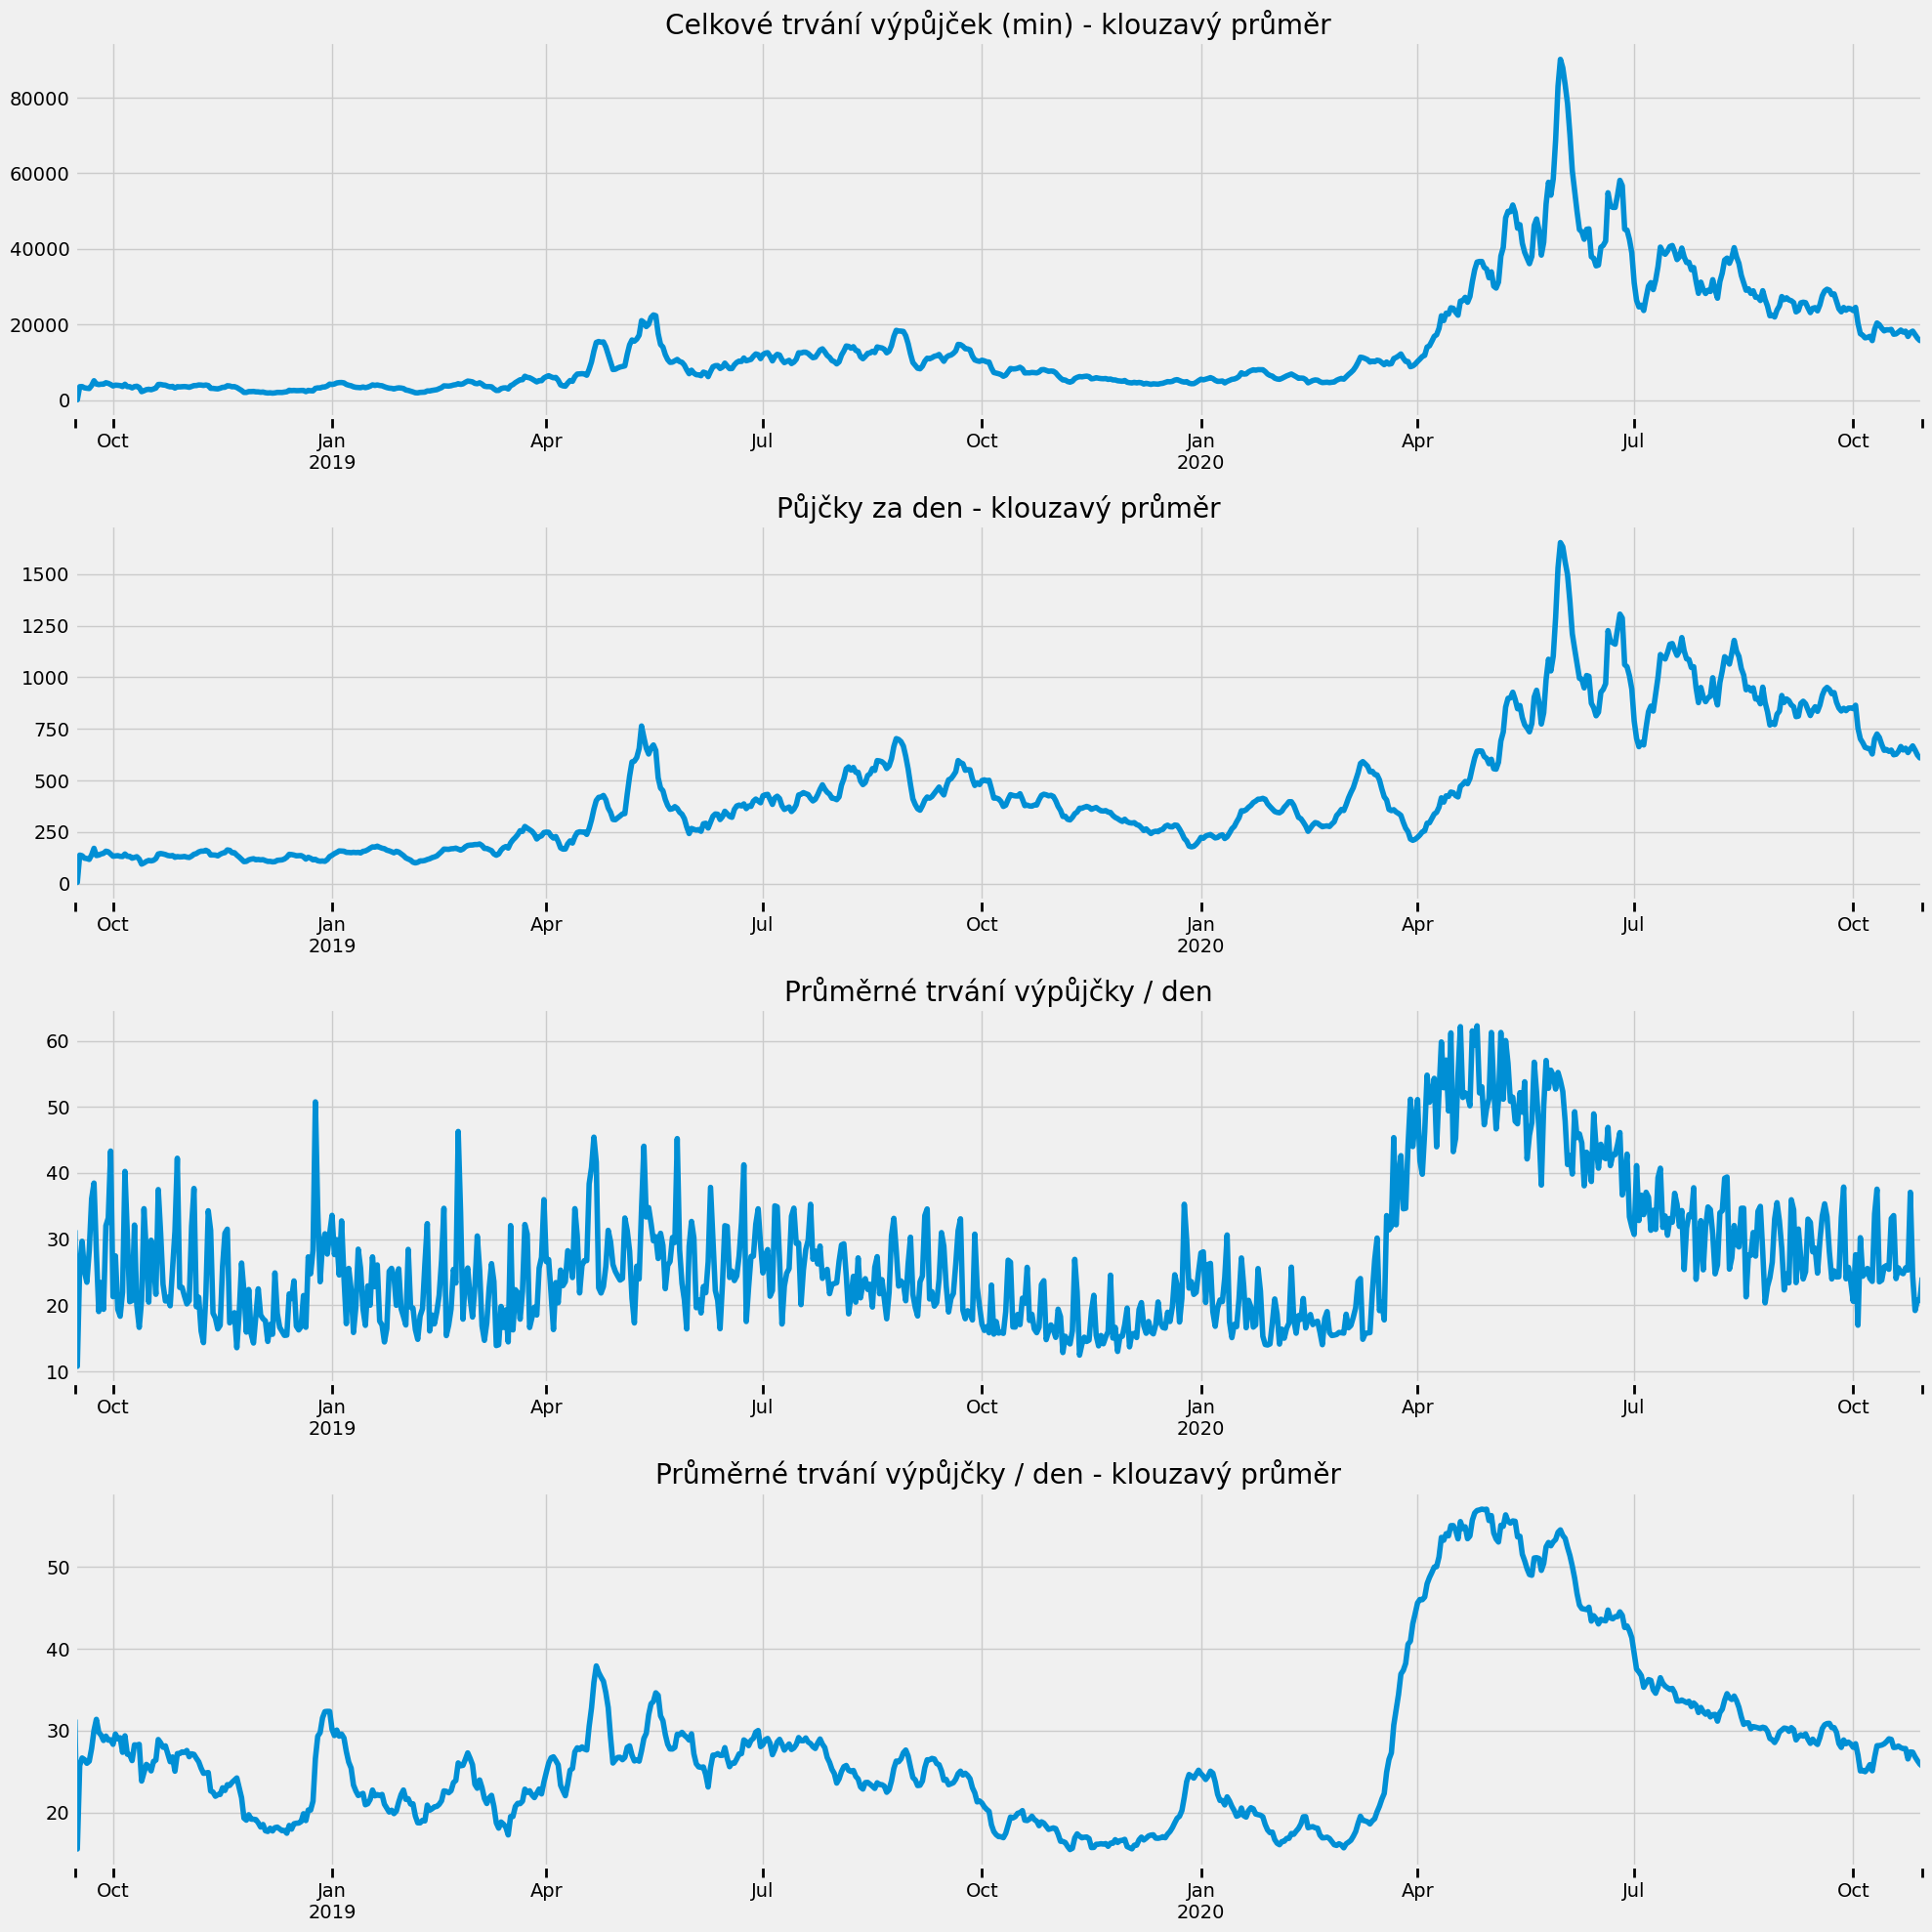

In [14]:
bikes_days_df["SMA_7_dur"] = bikes_days_df["sum (min)"].rolling(7, min_periods=1).mean()
bikes_days_df["SMA_7_count"] = bikes_days_df["count"].rolling(7, min_periods=1).mean()
bikes_days_df["average_duration2"] = bikes_days_df["SMA_7_dur"] / bikes_days_df["SMA_7_count"] 

colors = ["green", "red", "purple", "blue"]
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,20))



bikes_days_df["SMA_7_dur"].plot(ax=ax1, title= "Celkové trvání výpůjček (min) - klouzavý průměr")
bikes_days_df["SMA_7_count"].plot(ax=ax2, title="Půjčky za den - klouzavý průměr")
bikes_days_df["average_duration"].plot(ax=ax3, title="Průměrné trvání výpůjčky / den")
bikes_days_df["average_duration2"].plot(ax=ax4, title="Průměrné trvání výpůjčky / den - klouzavý průměr")
for ax in [ax1,ax2,ax3,ax4]:
    ax.set(xlabel="")
    ax.tick_params(axis="x",length=8,width=2)
    
fig.tight_layout()

plt.show()

## Porovnání výpůjček v týdnu

weekend           Working_Day     Weekend
sum (min)               100.0  141.791639
count                   100.0  112.491521
average_duration        100.0  125.149924

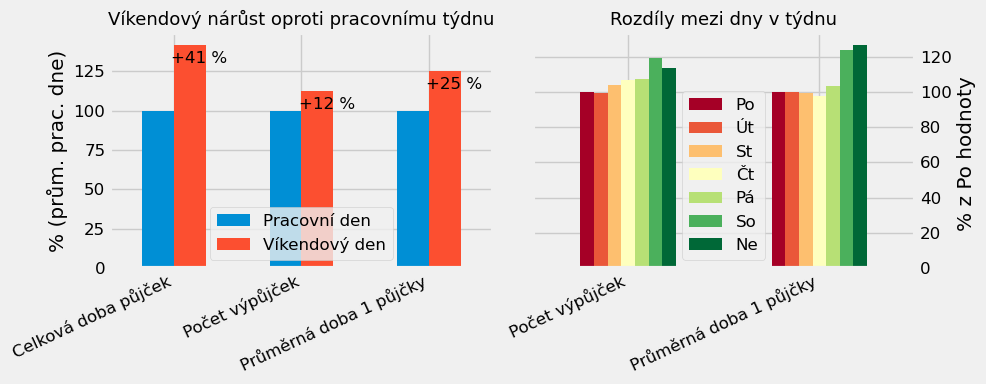

In [15]:
# normalize data, take first as 100%    
def aspercent(x):
    return (x*100 / x[0])
 
# create days of week and weekend flag
bikes_days_df["day_of_week"] = (bikes_days_df.index.dayofweek)
bikes_days_df["weekend"] = (bikes_days_df["day_of_week"] // 5 == 1)#.astype(int)
#group by weekend and count mean per 1 day
df = bikes_days_df.groupby("weekend")[["sum (min)", "count", "average_duration"]].sum()
df.loc[0] = df.loc[0]/5
df.loc[1] = df.loc[1]/2
df.rename(index= {False: "Working_Day", True: "Weekend"}, inplace=True)
df.columns.name = None
df2 = df.T.apply(aspercent,axis=1)   # convert to percent

#group by week days
df_7days = bikes_days_df.groupby("day_of_week")[["count", "average_duration"]].sum()

#make figure
matplotlib.rc('font', size='12')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

df2.plot.bar(ax = ax1, ylim=(0,149), rot=25,ylabel="% (prům. prac. dne)")
ax1.set_xticklabels(["Celková doba půjček","Počet výpůjček","Průměrná doba 1 půjčky"], ha="right",size="12")
ax1.set_title(label="Víkendový nárůst oproti pracovnímu týdnu",fontsize=13)
ax1.legend( ("Pracovní den","Víkendový den"),ncol=1, loc=8)
for i, p in enumerate(ax1.patches):
    if i > 2:
        ax1.annotate(f"+{int(p.get_height())-100} %", (p.get_x() * 1.0, p.get_height() * 1.005),  xytext=(-2, -14), textcoords='offset points')

df_7days.T.apply(aspercent,axis=1).plot.bar(ax=ax2,rot=25, ylabel="% z Po hodnoty ", colormap='RdYlGn')
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_label_position("right")
ax2.set_xticklabels(["Počet výpůjček","Průměrná doba 1 půjčky"], ha="right",size="12")
ax2.set_title(label="Rozdíly mezi dny v týdnu",fontsize=13)
ax2.legend( ["Po","Út","St","Čt","Pá","So","Ne"],ncol=1, loc=8)
plt.tight_layout()
df2

## Průběh výpůjček přes den

### V pracovní dny je patrná ranní a odpolední špička, s tím, že z práce jede domů na kole 2x více lidí než ráno do práce anebo odpoledne se k nim přidávají i někteří ti, co ráno jeli MHD

duration  start_station_id  hour  weekday  weekend
started_at                                                             
2018-09-15 08:52:05      1182               247     8        5        1
2018-09-15 09:24:33       995               259     9        5        1
2018-09-15 09:48:54      3466               262     9        5        1
2018-09-16 12:01:36      1430               255    12        6        1
2018-09-16 12:03:43       452               255    12        6        1
...                       ...               ...   ...      ...      ...
2020-10-30 23:27:35       665              1051    23        4        0
2020-10-30 23:33:50       372              1798    23        4        0
2020-10-30 23:38:57       275              1028    23        4        0
2020-10-30 23:41:26       557               358    23        4        0
2020-10-30 23:51:25       435              1730    23        4        0

[336965 rows x 5 columns]

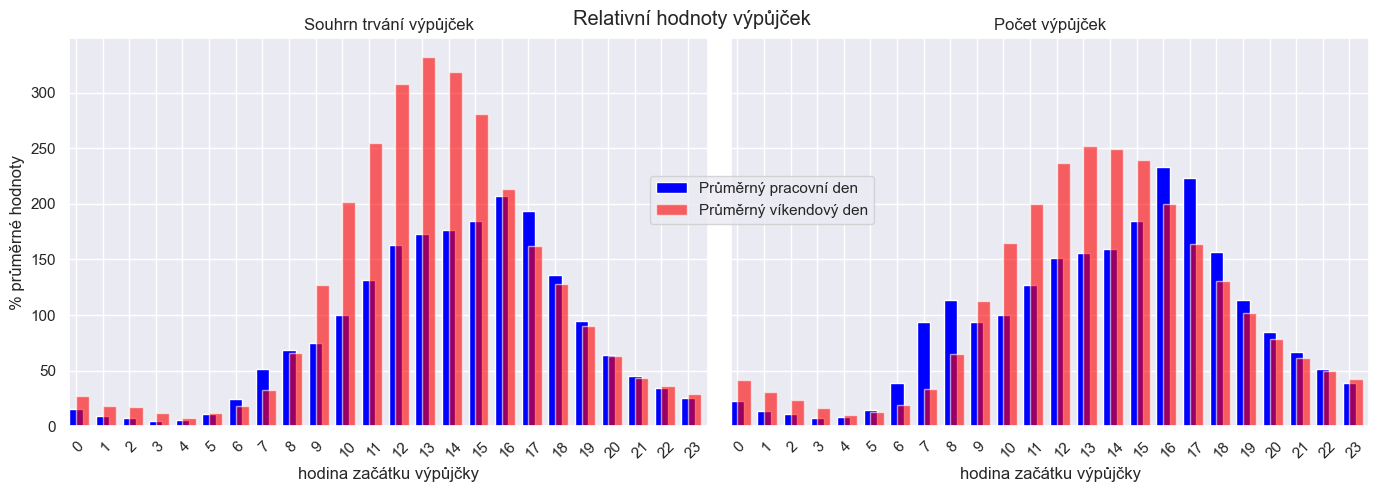

In [16]:
day_df = bikes_df[["started_at", "duration", "start_station_id"]].set_index("started_at").query("duration < 11000")
day_df = day_df.assign(hour=day_df.index.hour, weekday=day_df.index.weekday)
day_df["weekend"] = (day_df["weekday"] // 5 == 1).astype(int)
df = day_df.groupby(["weekend", "hour"]).agg({"duration": [lambda x: round(sum(x)/60,0)], "start_station_id": ["count"]})
# vydělení počtem pracovních a víkendových dnů pro porovnání
df.loc[[0]] = df.loc[[0]]/5
df.loc[[1]] = df.loc[[1]]/2
df.columns = ("duration (min)", "count")
sns.set(style="darkgrid")
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey="row")
color = ["blue","red"]
title = ["Souhrn trvání výpůjček", "Počet výpůjček"]
for i, column in enumerate(df.columns):
    mean_value = np.mean(df[column])
    df.loc[[0],[column]].apply(lambda x: x*100/mean_value, axis=0).droplevel(0).plot.bar(ax=ax[i], title=title[i], alpha=1, color=color[0], legend=None, ylabel="% průměrné hodnoty", xlabel="hodina začátku výpůjčky")
    df.loc[[1],[column]].apply(lambda x: x*100/mean_value, axis=0).droplevel(0).plot.bar(ax=ax[i],color=color[1], alpha=0.6, legend=None, xlabel="hodina začátku výpůjčky", align="edge")
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=45, ha='left')
    
fig.legend( ("Průměrný pracovní den","Průměrný víkendový den"),loc="center", bbox_to_anchor=[0.55,0.6])

plt.tight_layout()

# try to move ticks left:
import matplotlib.transforms
# Create offset transform by 4 points in x direction
dx = -4/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# apply offset transform to all x ticklabels.
for ax in ax:
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
fig.suptitle("Relativní hodnoty výpůjček")
day_df

### Průměrná délka výpůjčky v průběhu dne
Uprostřed dne je průměrná délka výpůjčky nejvyšší, což se dá předpokládat zejména o víkendu.  
V datasetu jsou zejména výpůjčky mezi 10-25 minutami. Ale je i hodně kratších a mnohem delších, což způsobuje velkou standardní odchylku dat a velký rozdíl mezi mediánem a průměrem.  
Lepší asi by bylo používat medián.  
Při oříznutí dat např. jen mezi 5 a 30 minutami má ale bar graf v průběhu dne přibližně stejný průběh jako bez jejich omezení.

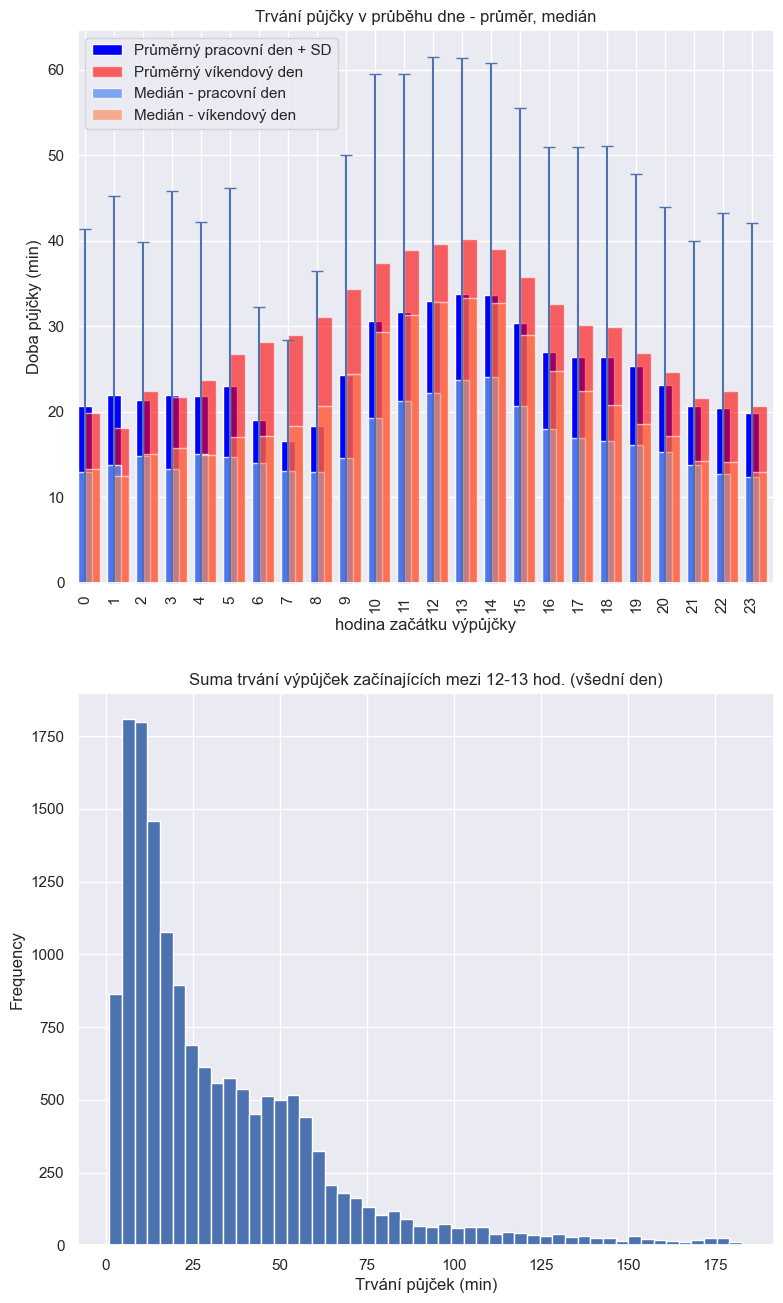

In [17]:
df = day_df.groupby(["weekend", "hour"]).agg({"duration": [lambda x: round(np.mean(x)/60,1),lambda x: np.std(x/60), lambda x: round(np.median(x)/60,1)]})
df.columns = ("avg duration (min)", "sd", "median duration (min)")
fig, (ax,ax2) = plt.subplots(2,1,figsize=(8,15))
df.loc[[0],"avg duration (min)"].droplevel(0).plot(kind="bar",ax=ax, title="Trvání půjčky v průběhu dne - průměr, medián", alpha=1, color=color[0], legend=None, ylabel="Doba půjčky (min)", xlabel="hodina začátku výpůjčky")
df.loc[[1],"avg duration (min)"].droplevel(0).plot(kind="bar",ax=ax,color=color[1], alpha=0.6, legend=None, xlabel="hodina začátku výpůjčky", align="edge")

df.loc[[0],"median duration (min)"].droplevel(0).plot(kind="bar",ax=ax, alpha=0.8, color="cornflowerblue", legend=None, ylabel="Doba půjčky (min)", xlabel="hodina začátku výpůjčky")
df.loc[[1],"median duration (min)"].droplevel(0).plot(kind="bar",ax=ax,color="coral", alpha=0.6, legend=None, xlabel="hodina začátku výpůjčky", align="edge")
ax.legend( ("Průměrný pracovní den + SD","Průměrný víkendový den", "Medián - pracovní den", "Medián - víkendový den"),loc="upper left")
ax.errorbar(df.loc[[0]].index.get_level_values(1), df.loc[[0]]["sd"], yerr=df.loc[[0]]["sd"], capsize=4, ls='none')
#df.loc[[0]].index.get_level_values(1)
#df.loc[[0]]["sd"]
(day_df[(day_df["hour"]==12) & (day_df["weekend"]==0)]["duration"]/60).plot(kind="hist",ax=ax2, bins=50, title="Suma trvání výpůjček začínajících mezi 12-13 hod. (všední den)")
plt.xlabel('Trvání půjček (min)');

# Vliv počasí

### Základní info o datasetu počasí a úprava tabulky

In [18]:
# základní info o weather - žádné nan, vše objekty
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6336 entries, 0 to 6335
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      6336 non-null   object
 1   temp      6336 non-null   object
 2   feels     6336 non-null   object
 3   wind      6336 non-null   object
 4   gust      6336 non-null   object
 5   rain      6336 non-null   object
 6   humidity  6336 non-null   object
 7   cloud     6336 non-null   object
 8   pressure  6336 non-null   object
 9   vis       6336 non-null   object
 10  date      6336 non-null   object
dtypes: object(11)
memory usage: 544.6+ KB


In [19]:
# úprava tabulky - vynechání nočních hodnot a úprava dat na čísla
pd.to_datetime(weather_df["time"], format= "%H:%M").astype("datetime64[h]")
weather_df["time"] = pd.to_datetime(weather_df["time"])
weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df2 = weather_df[(weather_df["time"].dt.hour > 3) & (weather_df["time"].dt.hour <= 21)].drop(["feels","vis","pressure"],axis=1)
weather_df2.replace(regex={r'\D*\Z':""}, inplace=True)
weather_df2.loc[:,"temp":"cloud"] = weather_df2.loc[:,"temp":"cloud"].apply(pd.to_numeric,downcast="integer")
weather_df2

time  temp  wind  gust  rain  humidity  cloud       date
2    2021-05-27 06:00:00    14    11    19   0.0        84    100 2018-09-01
3    2021-05-27 09:00:00    14    14    23   0.1        88     78 2018-09-01
4    2021-05-27 12:00:00    16    15    22   0.0        87     87 2018-09-01
5    2021-05-27 15:00:00    17    14    21   0.0        83     97 2018-09-01
6    2021-05-27 18:00:00    16    12    19   0.0        88     98 2018-09-01
...                  ...   ...   ...   ...   ...       ...    ...        ...
6331 2021-05-27 09:00:00    14    21    33   0.4        86    100 2020-10-31
6332 2021-05-27 12:00:00    14    24    37   0.4        88     94 2020-10-31
6333 2021-05-27 15:00:00    10    42    55   0.5        75    100 2020-10-31
6334 2021-05-27 18:00:00     9    38    54   0.0        76     79 2020-10-31
6335 2021-05-27 21:00:00     8    36    49   0.1        74     79 2020-10-31

[4752 rows x 8 columns]

##### Seskupení dat podle datumu, průměrné hodnoty, déšť celkový souhrn

In [20]:
weather_day_df = weather_df2.groupby("date").agg({"temp":"mean", "wind":"mean", "gust":"mean","rain":"sum","humidity":"mean","cloud":"mean"}).round(1)
weather_day_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792 entries, 2018-09-01 to 2020-10-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      792 non-null    float64
 1   wind      792 non-null    float64
 2   gust      792 non-null    float64
 3   rain      792 non-null    float64
 4   humidity  792 non-null    float64
 5   cloud     792 non-null    float64
dtypes: float64(6)
memory usage: 43.3 KB


#### Průzkum korelace mezi jednotlivými veličinami
Párový graf ze všech veličin  
Heatmap spearmanova koeficientu - Pearson vyjde podobně,ale není úplně vypovídající, protože u většiny není normální rozložení, hlavně u "rain" je rozdíl

Závěr:
"wind" a "gust" silně koreluje, gust vynechám z dalších analýz, teplota má gauss rozložení, ostatní trochu zešikmené  
Po většinu roku je zataženo, při oblačnosti nad 50% a s vyšší vlhostí roste možnost deště, ale oblačnost s vlhostí skoro nekorelují

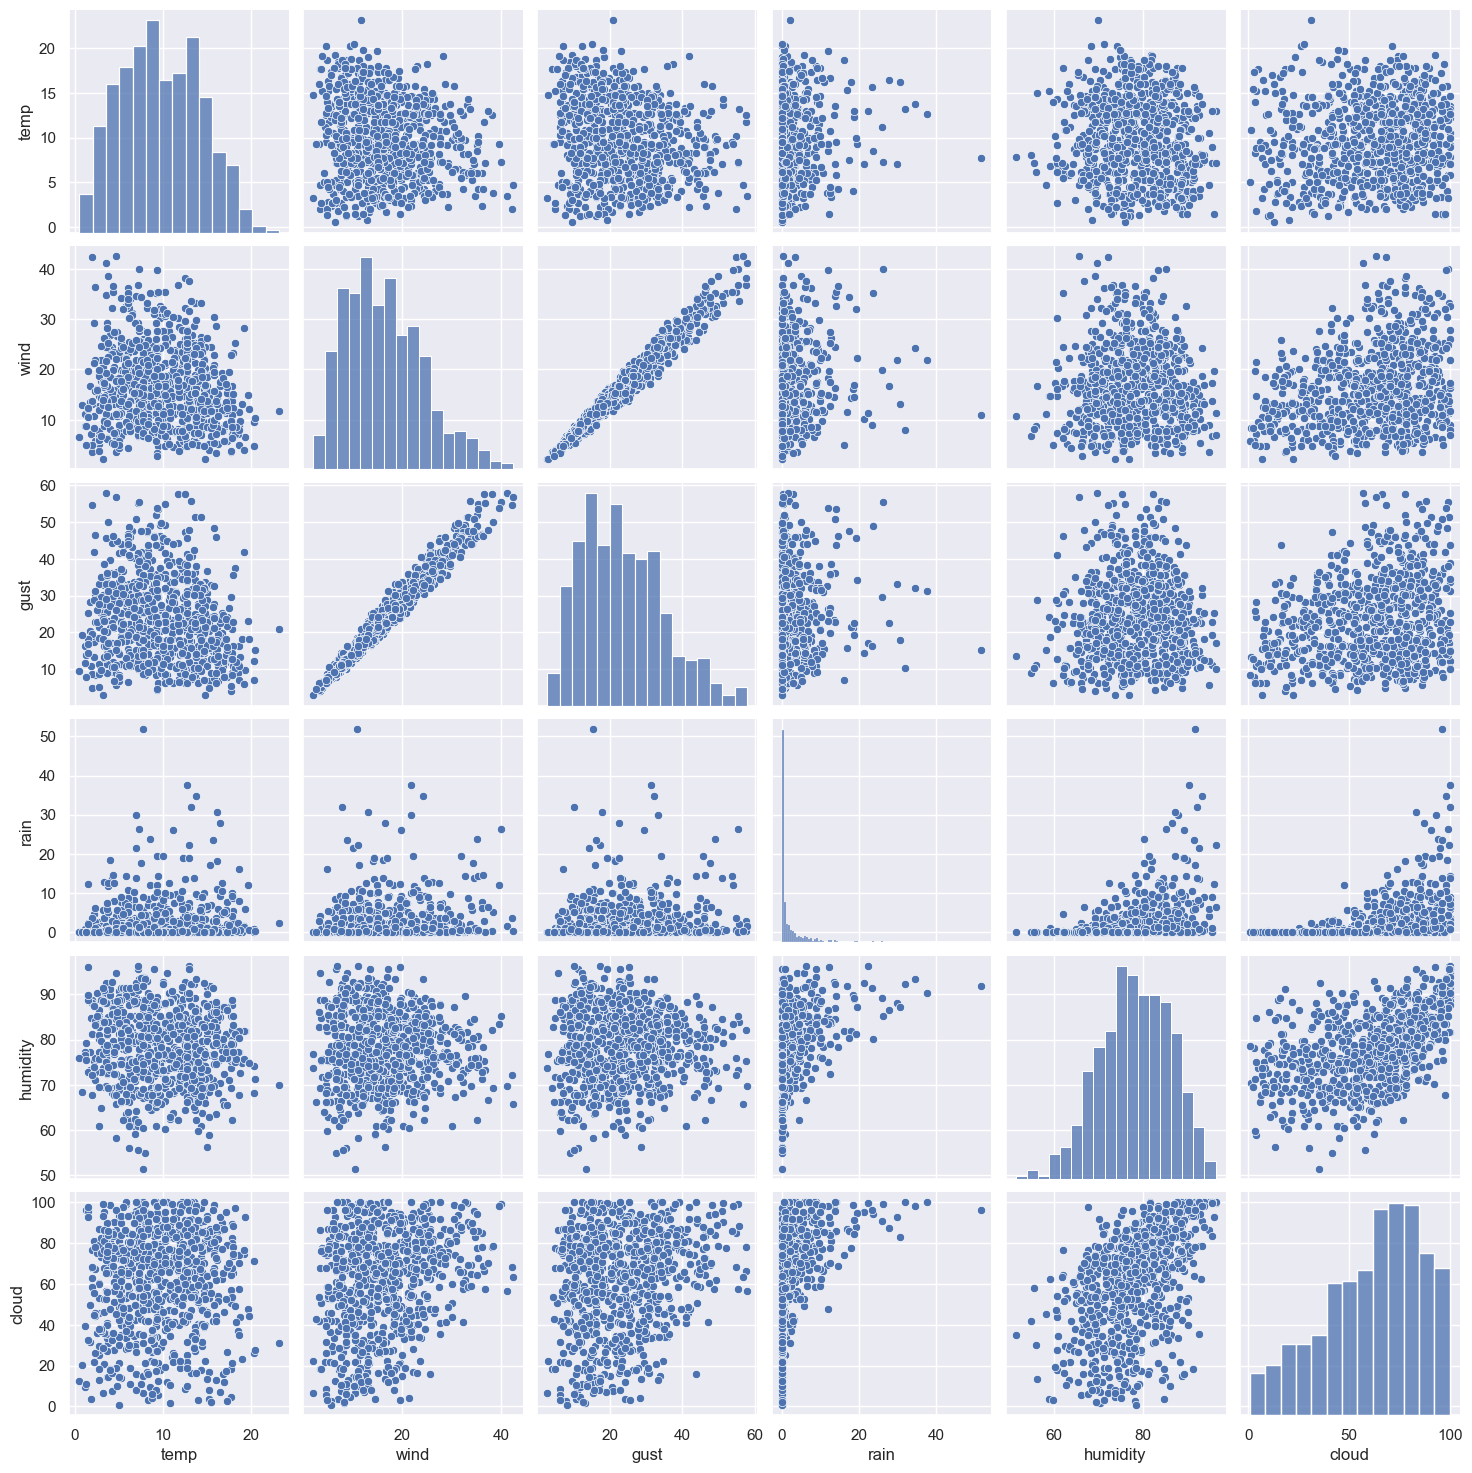

In [21]:
df = weather_day_df.loc[:,"temp":"cloud"]
sns.pairplot(df)
plt.show()
# 

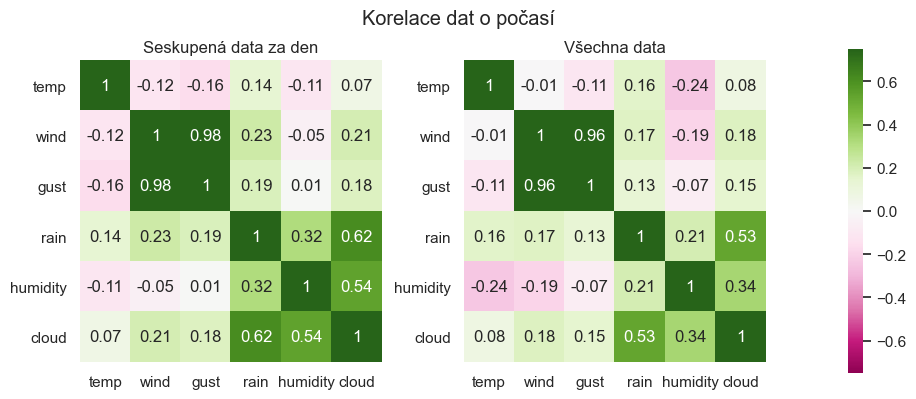

In [22]:
grid_kws = {"wspace": 0.4, "width_ratios":[0.1,0.1,0.005]}
fig, (ax1, ax2, cbar_ax) = plt.subplots(1,3, figsize=(9,4), gridspec_kw=grid_kws)
sns.heatmap(weather_day_df.corr(method="spearman").round(2), ax=ax1,square = True, cmap="PiYG", center=0,vmin=-0.75,vmax=0.75,annot=True, cbar=False )
sns.heatmap(weather_df2.loc[:,"temp":"cloud"].corr(method="spearman").round(2),ax=ax2,square = True, cmap="PiYG", center=0,vmin=-0.75,vmax=0.75,annot=True,cbar_ax=cbar_ax, cbar_kws={"shrink": 0.5}, )
ax1.set_title(label="Seskupená data za den")
ax2.set_title(label="Všechna data")
fig.suptitle("Korelace dat o počasí")

plt.draw()


(array([14., 15., 16., 18., 15., 18., 19., 17., 17., 30., 22., 27., 16.,
        36., 26., 32., 32., 36., 39., 36., 36., 47., 39., 27., 40., 26.,
        26., 18., 19., 33.]),
 array([-2.14304443, -2.01513658, -1.88722872, -1.75932086, -1.63141301,
        -1.50350515, -1.3755973 , -1.24768944, -1.11978159, -0.99187373,
        -0.86396588, -0.73605802, -0.60815016, -0.48024231, -0.35233445,
        -0.2244266 , -0.09651874,  0.03138911,  0.15929697,  0.28720482,
         0.41511268,  0.54302053,  0.67092839,  0.79883625,  0.9267441 ,
         1.05465196,  1.18255981,  1.31046767,  1.43837552,  1.56628338,
         1.69419123]),
 <BarContainer object of 30 artists>)

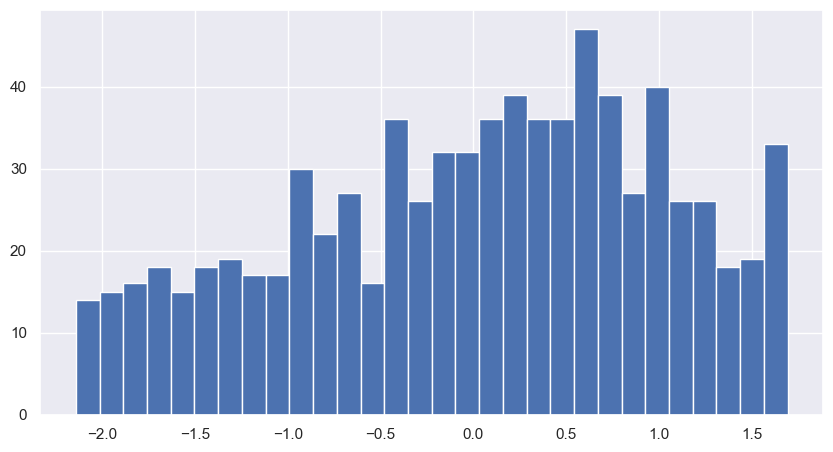

In [23]:
# Normalizace a standardizace dat
# np.log(weather_df2[["rain"]]+0.05).plot.hist()  PowerTransformer() -wind,rain,humidity,cloud  StandardScaler() - temp? 
# cloud rovnomerne rozlozeni u všech dat, u groupovaných na průměr za den, posunuté hodnoty k vyšší oblačnosti
bc = PowerTransformer()
bc_data = bc.fit_transform(weather_day_df[["cloud"]])
fig,ax = plt.subplots(figsize=(9,5))
ax.hist(bc_data,bins=30)


## Souvislost výpůjček na počasí

In [24]:
weather_day_df
bikes_weather_df = bikes_days_df[["sum (min)", "count","average_duration"]].join(weather_day_df)
bikes_weather_df


sum (min)  count  average_duration  temp  wind  gust  rain  \
started_at                                                                  
2018-09-15     94.050000    3.0         31.350000  11.7  15.2  22.5   1.0   
2018-09-16    107.650000   10.0         10.765000  12.8  25.7  41.3   0.2   
2018-09-17  10503.000000  403.0         26.062035  15.0  18.8  30.7   0.2   
2018-09-18   3738.850000  126.0         29.673413  14.0  17.0  27.7   1.9   
2018-09-19   1906.266667   76.0         25.082456  11.7  36.7  57.7   2.9   
...                  ...    ...               ...   ...   ...   ...   ...   
2020-10-26  13628.900000  560.0         24.337321   9.0  18.7  26.3   1.3   
2020-10-27   8390.900000  437.0         19.201144   7.3  15.3  21.5   1.0   
2020-10-28  11628.766667  559.0         20.802803   7.3  24.5  33.0   1.2   
2020-10-29   9897.783333  478.0         20.706660   6.7  15.3  24.2  10.1   
2020-10-30  18625.200000  770.0         24.188571   9.5  16.8  22.5   0.1   

            humidity  cloud  
started_at                   
2018-09-15      81.2   72.0  
2018-09-16      79.3   75.8  
2018-09-17      80.7   77.0  
2018-09-18      86.5   67.8  
2018-09-19      75.3   66.2  
...              ...    ...  
2020-10-26      82.5   69.8  
2020-10-27      85.2   58.2  
2020-10-28      83.3   92.5  
2020-10-29      88.5   89.7  
2020-10-30      76.5   52.5  

[777 rows x 9 columns]

### Závislost počtu výpůjček na počasí
#### Orientační zobrazení závislosti počtu výpůjček na parametrech počasí

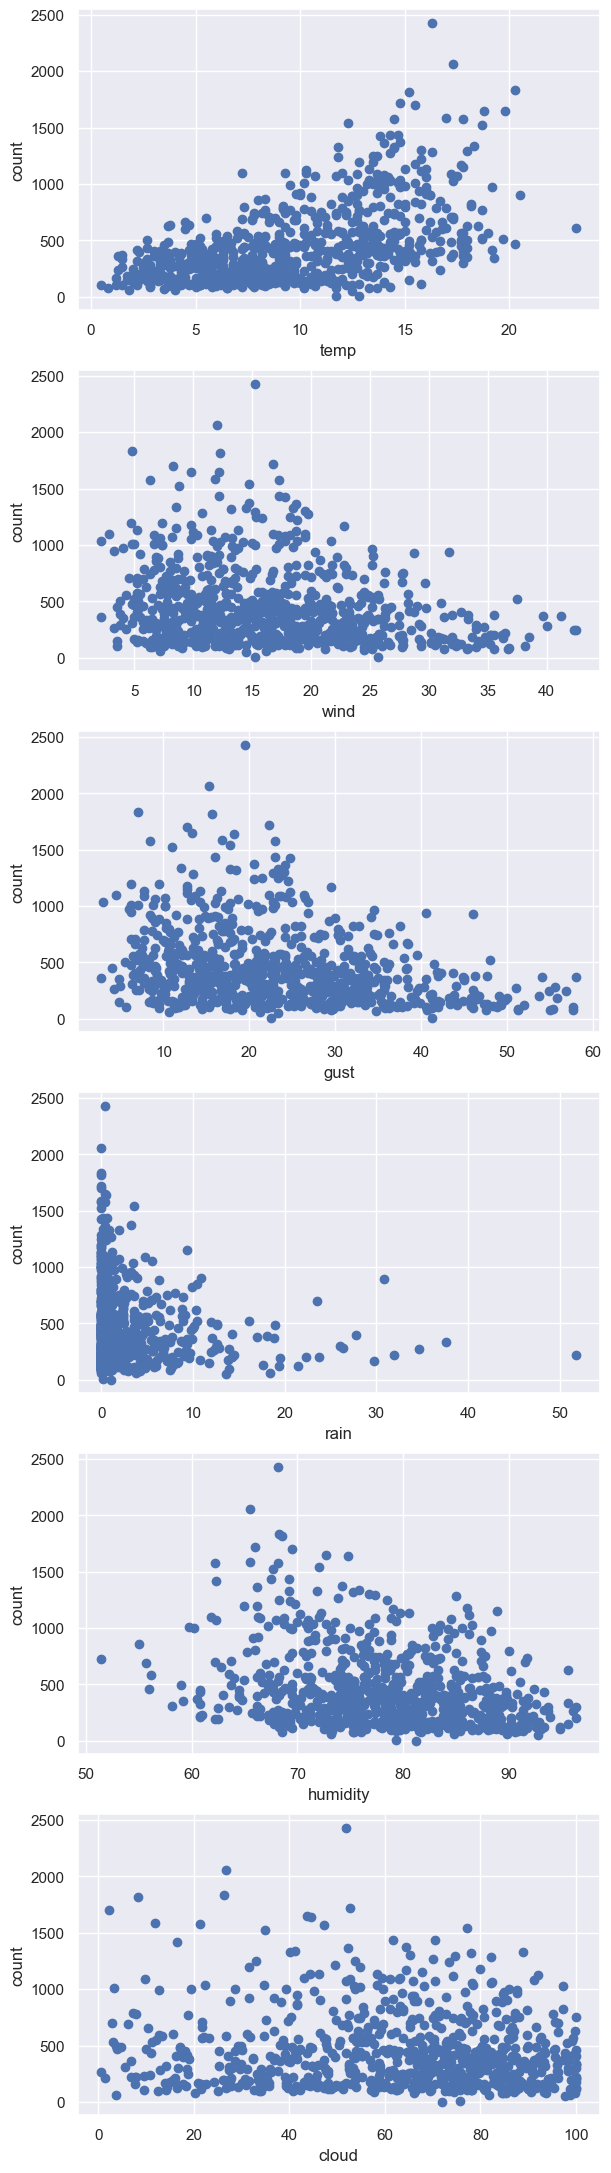

In [25]:
# Použita nenormalizovaná data počasí
column = 'count'
df2 = bikes_weather_df.drop(["count","sum (min)","average_duration"],axis=1)
# df2.index = bikes_weather[col]
fig,ax = plt.subplots(len(df2.columns),1, figsize=(6,26))

for i, col in enumerate(df2.columns):
    ax[i].scatter(df2[col],bikes_weather_df[column] )
    ax[i].set_ylabel(column)
    ax[i].set_xlabel(col)
# df2.plot(subplots=True, style='.', figsize=(10,30))
# plt.legend(loc='best')
# plt.show()

### Korelace ukazatelů počasí a délky a počtu výpůjček
<b>Počet i délka výpůjček nejvíce koreluje s teplotou přes den, poryvy větru a vlhostí vzduchu</b>

<AxesSubplot:>

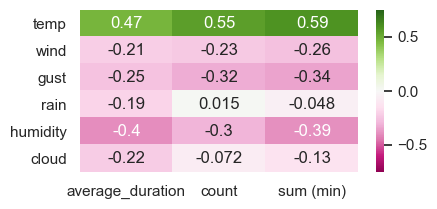

In [26]:
focus_cols=["average_duration","count","sum (min)"]
weather_bikes_corr = bikes_weather_df.corr(method="spearman").filter(focus_cols).drop(focus_cols)
f,ax = plt.subplots(figsize=(4,2))
sns.heatmap(weather_bikes_corr, cmap="PiYG", center=0,vmin=-0.75,vmax=0.75,annot=True )


#### vyjde stejně jako s transformací - spearman jí nepotřebuje:

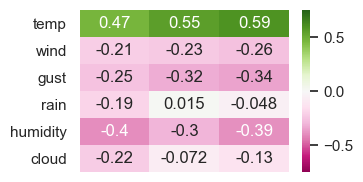

In [27]:
bc_data = bc.fit_transform(bikes_weather_df)
bc_data_df = pd.DataFrame(bc_data, columns=bikes_weather_df.columns)
bc_data_df
focus_cols=["average_duration","count","sum (min)"]
weather_bikes_corr2 = bc_data_df.corr(method="spearman").filter(focus_cols).drop(focus_cols)
f,ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(weather_bikes_corr2, cmap="PiYG", center=0,vmin=-0.75,vmax=0.75,annot=True,xticklabels=False )

### Ukázání vlivu deště, podle kategorizace
Jelikož v Británii prší často, tak je asi velké množství půjček, které jsou vždy, ať prší nebo ne, jak je vidět pak dál, tak vliv počasí (deště,oblačnosti a vlhkosti vzduchu) je větší po velkém nárůstu půjček na jaře 2020.  
Po kategorizaci dnů podle množství srážek, je vidět pokles ve dnech se silným deštěm hlavně co se týká průměrné doby výpůjčky, postupně také s deštěm ubývá odlehlých vysokých hodnot počtu půjček. Pokles je výrazný hlavně o víkendech.

In [28]:
bikes_weather_df["rain_cat"] = np.select(
    [bikes_weather_df["rain"] <= 0.4,
    bikes_weather_df["rain"] <= 1.5,
    bikes_weather_df["rain"] <=10,
    bikes_weather_df["rain"] > 10],
    ["bez deště", "lehký déšť", "déšť", "silný déšť"]
)
bikes_weather_df["rain_cat"] = bikes_weather_df["rain_cat"].astype("category")
bikes_weather_df.sort_values(by="count")

sum (min)   count  average_duration  temp  wind  gust  rain  \
started_at                                                                    
2018-09-15      94.050000     3.0         31.350000  11.7  15.2  22.5   1.0   
2018-09-16     107.650000    10.0         10.765000  12.8  25.7  41.3   0.2   
2018-10-13    1018.533333    49.0         20.786395  12.5  14.5  23.3  13.6   
2019-03-16     852.850000    59.0         14.455085   4.0  16.2  21.2  18.4   
2018-12-24    1726.316667    61.0         28.300273   1.8   7.2  10.7   0.0   
...                   ...     ...               ...   ...   ...   ...   ...   
2020-05-25   98115.566667  1721.0         57.010788  14.8  16.8  22.3   0.0   
2020-05-31   98143.458333  1819.0         53.954623  15.2  12.3  15.7   0.0   
2020-05-29   96511.483333  1832.0         52.680941  20.3   4.8   7.0   0.0   
2020-05-30  113715.350000  2060.0         55.201626  17.3  12.0  15.3   0.0   
2020-06-20  113862.166667  2428.0         46.895456  16.3  15.2  19.5   0.4   

            humidity  cloud    rain_cat  
started_at                               
2018-09-15      81.2   72.0  lehký déšť  
2018-09-16      79.3   75.8   bez deště  
2018-10-13      92.7   97.7  silný déšť  
2019-03-16      89.8   98.7  silný déšť  
2018-12-24      84.8    3.7   bez deště  
...              ...    ...         ...  
2020-05-25      66.0   52.7   bez deště  
2020-05-31      68.5    8.3   bez deště  
2020-05-29      68.3   26.3   bez deště  
2020-05-30      65.5   26.7   bez deště  
2020-06-20      68.2   51.8   bez deště  

[777 rows x 10 columns]

In [29]:

bikes_weather_df = bikes_weather_df.join(bikes_days_df["weekend"].astype(int))


Text(0.5, 0.98, 'Vliv deště na počet a dobu trvání půjček v pracovní dny a víkendy')

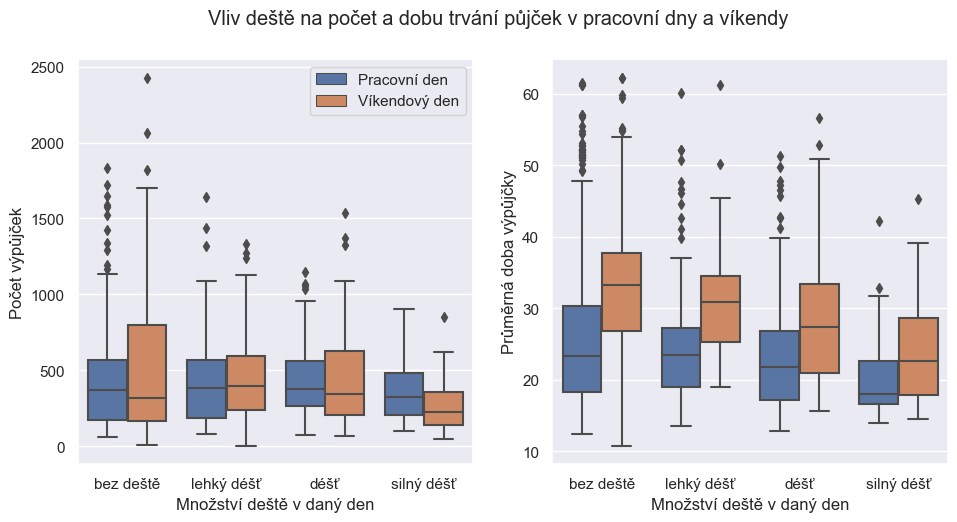

In [30]:
sns.set(style="darkgrid")
fig,ax = plt.subplots(1,2,figsize=(10,5))
ylabels=["Počet výpůjček", "Průměrná doba výpůjčky"]
for i, column in enumerate(["count","average_duration"]):
    ax[i] = sns.boxplot(ax=ax[i],y=column,x="rain_cat", data=bikes_weather_df,hue="weekend", order=["bez deště", "lehký déšť", "déšť", "silný déšť"])
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].set_xlabel("Množství deště v daný den")
    ax[i].set_ylabel(ylabels[i])
ax[1].legend_.remove()
ax[0].legend( handles,("Pracovní den","Víkendový den"),loc="upper right")
plt.suptitle("Vliv deště na počet a dobu trvání půjček v pracovní dny a víkendy")


# Seskupení dat o počasí - PCA
### nakonec jsem zvolil 2 PCA proměnné

In [31]:
features = ["temp", "wind","rain", "humidity","cloud"]

x = bikes_weather_df[features]
x = PowerTransformer().fit_transform(x)
df = pd.DataFrame(x, columns=features)
PCA_df = PCA(n_components=2)
weather_PCA = PCA_df.fit_transform(df)
weather_PCA_df = pd.DataFrame(weather_PCA, columns=["PCA1","PCA2"])
print("PCA explained variance ratio: ", PCA_df.explained_variance_ratio_)

w = bikes_weather_df[["count", "average_duration"]+features+["weekend"]]
w["PCA1"] = weather_PCA_df["PCA1"].values
w["PCA2"] = weather_PCA_df["PCA2"].values
#plt.scatter(w[["PCA1"]], w[["average_duration"]])
w

PCA explained variance ratio:  [0.4094958 0.2211729]


<ipython-input-31-f46ffc065ad1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["PCA1"] = weather_PCA_df["PCA1"].values
<ipython-input-31-f46ffc065ad1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["PCA2"] = weather_PCA_df["PCA2"].values


count  average_duration  temp  wind  rain  humidity  cloud  \
started_at                                                               
2018-09-15    3.0         31.350000  11.7  15.2   1.0      81.2   72.0   
2018-09-16   10.0         10.765000  12.8  25.7   0.2      79.3   75.8   
2018-09-17  403.0         26.062035  15.0  18.8   0.2      80.7   77.0   
2018-09-18  126.0         29.673413  14.0  17.0   1.9      86.5   67.8   
2018-09-19   76.0         25.082456  11.7  36.7   2.9      75.3   66.2   
...           ...               ...   ...   ...   ...       ...    ...   
2020-10-26  560.0         24.337321   9.0  18.7   1.3      82.5   69.8   
2020-10-27  437.0         19.201144   7.3  15.3   1.0      85.2   58.2   
2020-10-28  559.0         20.802803   7.3  24.5   1.2      83.3   92.5   
2020-10-29  478.0         20.706660   6.7  15.3  10.1      88.5   89.7   
2020-10-30  770.0         24.188571   9.5  16.8   0.1      76.5   52.5   

            weekend      PCA1      PCA2  
started_at                               
2018-09-15        1 -0.606438  0.474378  
2018-09-16        1 -0.345153 -0.089235  
2018-09-17        0 -0.317533  0.664120  
2018-09-18        0 -1.162984  0.769660  
2018-09-19        0 -0.991741 -0.581296  
...             ...       ...       ...  
2020-10-26        0 -0.809049 -0.224365  
2020-10-27        0 -0.446486 -0.369493  
2020-10-28        0 -1.604819 -0.854696  
2020-10-29        0 -2.269680 -0.274524  
2020-10-30        0  0.820792 -0.193790  

[777 rows x 10 columns]

### PCA1 se vztahuje k: humidity, cloud a rain

### PCA2 se vztahuje k: temp a wind:

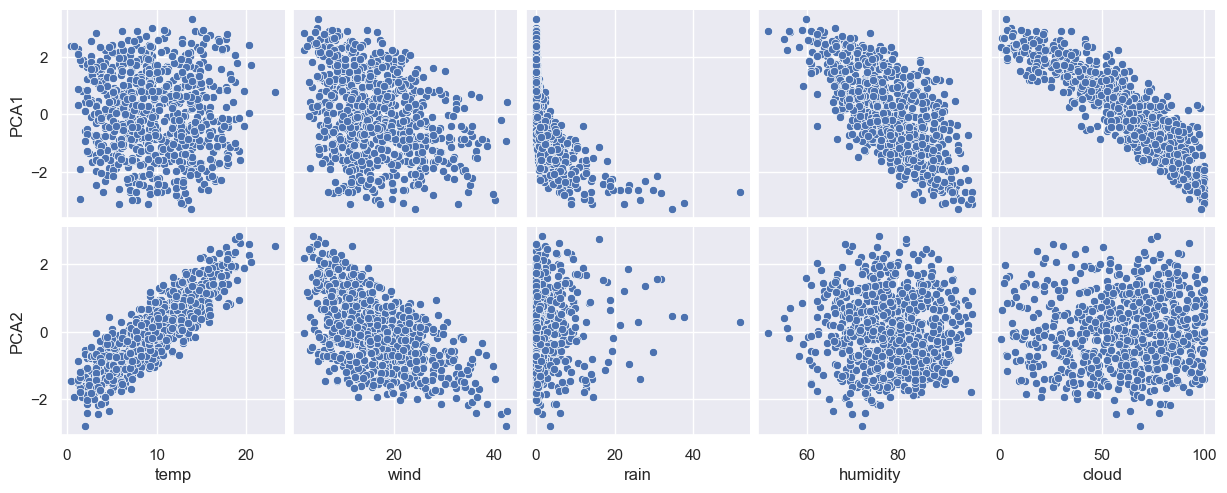

In [32]:
df = w.loc[:,"temp": ]
sns.pairplot(df ,x_vars=features, y_vars=["PCA1","PCA2"],diag_kind=None)
plt.show()

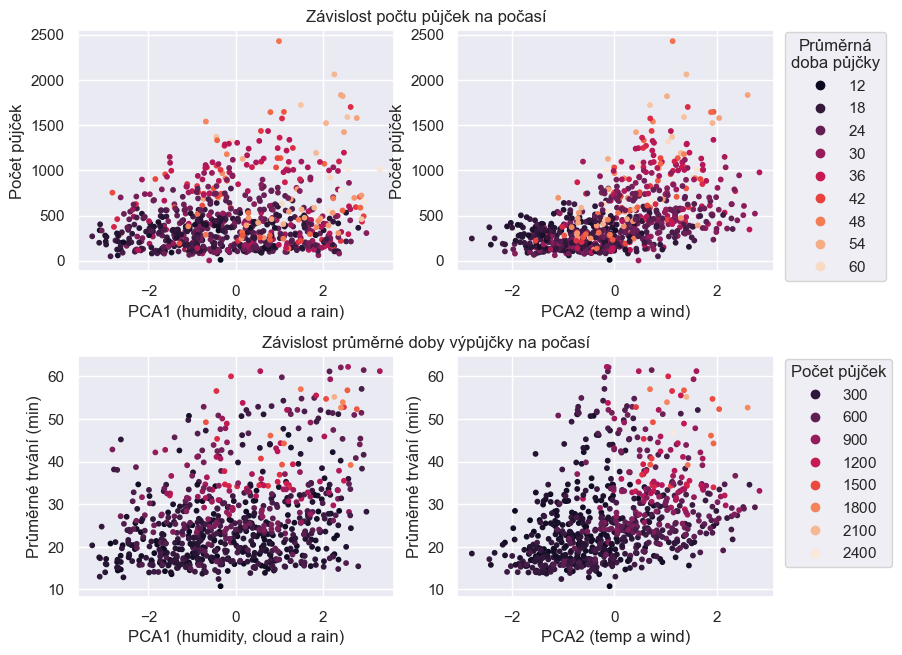

In [33]:
#Závislost půjček na počasí
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(221, ylabel="Počet půjček", xlabel="PCA1 (humidity, cloud a rain)")
ax.set_title('Závislost počtu půjček na počasí',x=1.1)
sc = ax.scatter(w['PCA1'], w['count'], c=w["average_duration"], s=10, alpha=1)
ax2 = fig.add_subplot(222, ylabel="Počet půjček", xlabel="PCA2 (temp a wind)")
ax2.scatter(w['PCA2'], w['count'], c=w["average_duration"], s=10, alpha=1)

ax3 = fig.add_subplot(223, ylabel="Průměrné trvání (min)", xlabel="PCA1 (humidity, cloud a rain)")
ax3.set_title('Závislost průměrné doby výpůjčky na počasí',x=1.1)
sc2 = ax3.scatter(w['PCA1'], w['average_duration'], c=w["count"], s=10, alpha=1)
ax4 = fig.add_subplot(224, ylabel="Průměrné trvání (min)", xlabel="PCA2 (temp a wind)")
ax4.scatter(w['PCA2'], w['average_duration'], c=w["count"], s=10, alpha=1)

# legend
l = plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.01, 1.28), loc=3, title="Průměrná\ndoba půjčky")
plt.setp(l.get_title(), multialignment="center")
l2 = plt.legend(*sc2.legend_elements(), bbox_to_anchor=(1.01, 1.02), loc=2, title="Počet půjček")
plt.gca().add_artist(l)
#fig.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()

#### Z grafů je vidět závislost počtu výpůjček i průměrné doby výpůjčky na počasí. Podle barevného kódu je naznačené i seskupení dat podle celkového počtu i průměrné doby výpůjčky. Podobnou závislost má skupina kratších půjček i dny s nižším počtem půjček.  
#### Nabízí se rozdělení půjček před a po jaru 2020, kde výrazně narostl počet půjček i jejich průměrná délka:


In [34]:
w["date_group"] = np.where(w.index < "2020-03-21", 0, 1)  # hlásí mi "SettingWithCopyWarning" ?
w

count  average_duration  temp  wind  rain  humidity  cloud  \
started_at                                                               
2018-09-15    3.0         31.350000  11.7  15.2   1.0      81.2   72.0   
2018-09-16   10.0         10.765000  12.8  25.7   0.2      79.3   75.8   
2018-09-17  403.0         26.062035  15.0  18.8   0.2      80.7   77.0   
2018-09-18  126.0         29.673413  14.0  17.0   1.9      86.5   67.8   
2018-09-19   76.0         25.082456  11.7  36.7   2.9      75.3   66.2   
...           ...               ...   ...   ...   ...       ...    ...   
2020-10-26  560.0         24.337321   9.0  18.7   1.3      82.5   69.8   
2020-10-27  437.0         19.201144   7.3  15.3   1.0      85.2   58.2   
2020-10-28  559.0         20.802803   7.3  24.5   1.2      83.3   92.5   
2020-10-29  478.0         20.706660   6.7  15.3  10.1      88.5   89.7   
2020-10-30  770.0         24.188571   9.5  16.8   0.1      76.5   52.5   

            weekend      PCA1      PCA2  date_group  
started_at                                           
2018-09-15        1 -0.606438  0.474378           0  
2018-09-16        1 -0.345153 -0.089235           0  
2018-09-17        0 -0.317533  0.664120           0  
2018-09-18        0 -1.162984  0.769660           0  
2018-09-19        0 -0.991741 -0.581296           0  
...             ...       ...       ...         ...  
2020-10-26        0 -0.809049 -0.224365           1  
2020-10-27        0 -0.446486 -0.369493           1  
2020-10-28        0 -1.604819 -0.854696           1  
2020-10-29        0 -2.269680 -0.274524           1  
2020-10-30        0  0.820792 -0.193790           1  

[777 rows x 11 columns]

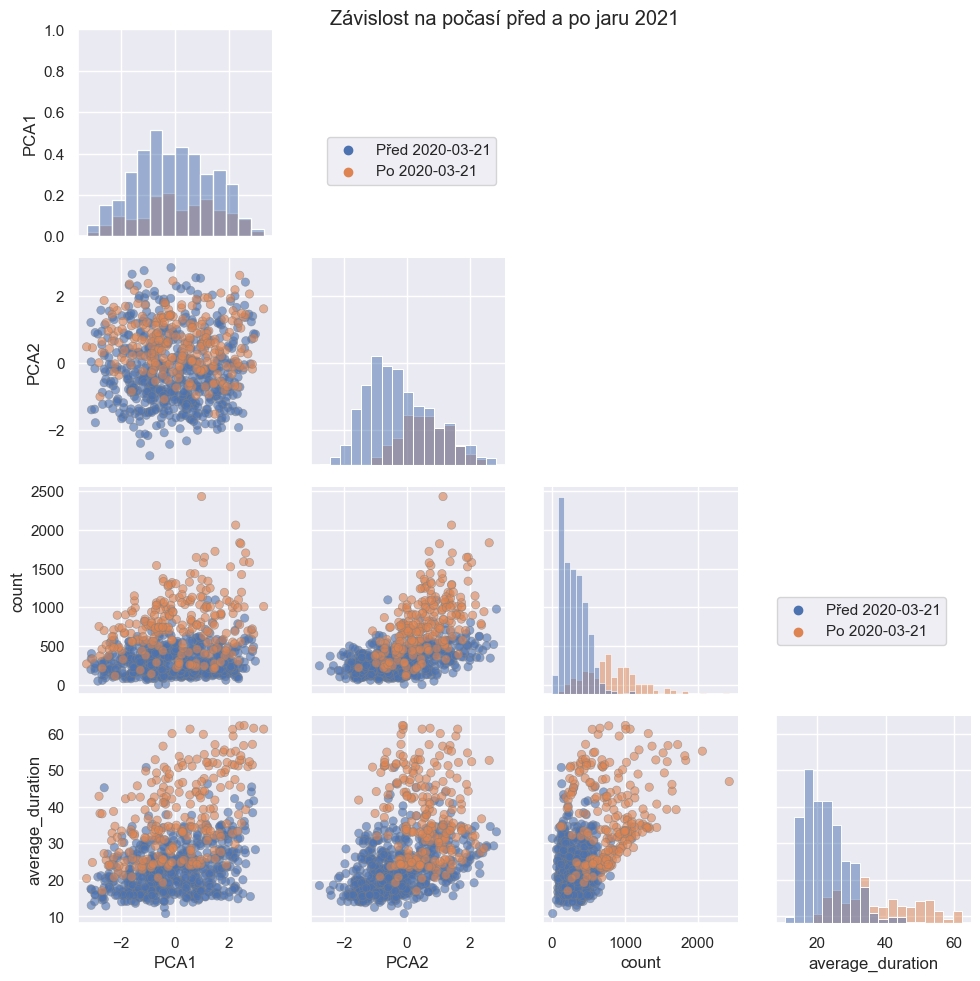

In [35]:
def hide_axis(*args,**kwds):
    plt.gca().set_visible(False)
    
pca_plot = sns.PairGrid(w[["PCA1","PCA2","count","average_duration","date_group"]], hue="date_group").map_lower(sns.scatterplot, alpha=0.6,edgecolor="grey").map_diag(sns.histplot).map_upper(hide_axis)
pca_plot.fig.subplots_adjust(top=0.96)
pca_plot.fig.suptitle('Závislost na počasí před a po jaru 2021')

handles = pca_plot._legend_data.values()
pca_plot.fig.legend(handles=handles, labels=("Před 2020-03-21","Po 2020-03-21"), ncol=1, bbox_to_anchor=(0.5, 0.86))
pca_plot.fig.legend(handles=handles, labels=("Před 2020-03-21","Po 2020-03-21"), ncol=1, bbox_to_anchor=(0.95, 0.4))
plt.show(pca_plot)


### Data před "covidem" mají mají jinou distribuci (histogram) i jinou závislost na počasí. Může to být asi jak změnou struktury půjček a chování lidí při "covidu" a také částečně tím, že nejsou z roku 2020 už zahrnuta data za zimní měsíce.
<b>Např. před jarem 2020 nebyl počet výpůjček závislý na vlhkosti,oblačnosti a dešti(PCA1) a na teplotě a větru (PCA2) jen trochu. Po tomto datu je závislost počtu výpůjček viditelná, i když třeba u PCA1 vychází,že je stále část dnů s nižšími výpůjčkami (do 500-600), které jsou nezávísle na PCA1 počasí rovnoměrně rozložené podobně jako před jarem 2020.</b>

### Zobrazení závislosti počtu výpůjček před a po 03/2020
#### Při zvýraznění víkendových dnů není skoro patrný rozdíl závislosti na počasí mezi víkendem a všedními dny.  Někde je znatelný vyšší počet půjček o víkendu než ve všední den.

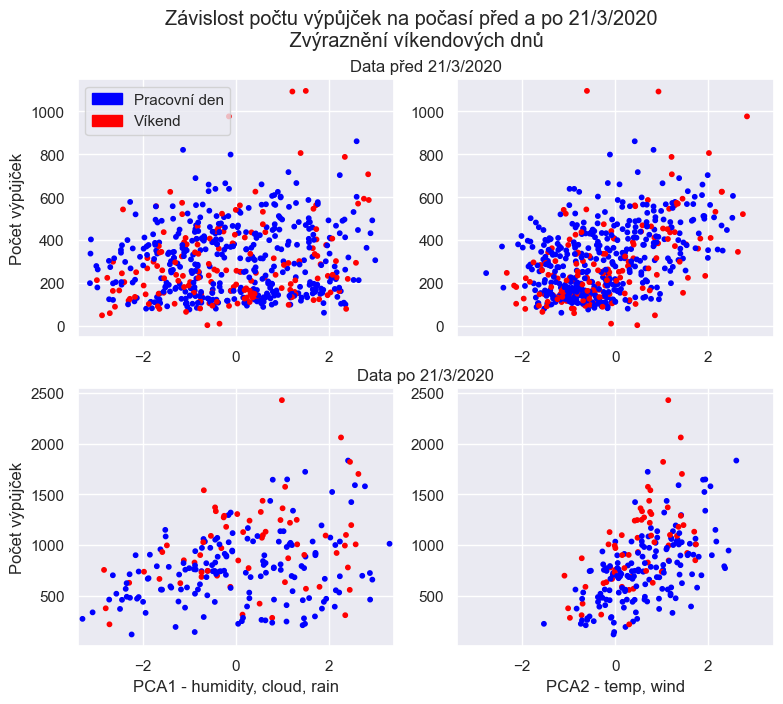

In [36]:
pca_names=["PCA1","PCA2"]
pca_names2=[" - humidity, cloud, rain", " - temp, wind"]
pca_min = [w["PCA1"].min()-0.1, w["PCA2"].min()-0.1]
pca_max = [w["PCA1"].max()+0.1, w["PCA2"].max()+0.1]
graph_columns_df=[w[w.index < '2020-03-21'],w[w.index > '2020-03-21']]
colors={0:"blue",1:"red"}

fig, all_ax = plt.subplots(2,2,figsize=(8,7))
for i, row in enumerate(all_ax):
    for j,ax in enumerate(row):
        z=graph_columns_df[i]
        if i==1: ax.set_xlabel(pca_names[j]+pca_names2[j])
        if j==0: ax.set_ylabel("Počet výpůjček")
        ax.set_xlim([pca_min[0],pca_max[0]])
        ax.scatter(z[pca_names[j]], z['count'], c=z["weekend"].map(colors), s=10, alpha=1)

day0 = mpatches.Patch(color=colors[0], label='Pracovní den')
day1 = mpatches.Patch(color=colors[1], label='Víkend')
all_ax[0][0].legend(handles=[day0,day1],loc="upper left")
plt.suptitle("Závislost počtu výpůjček na počasí před a po 21/3/2020 \n Zvýraznění víkendových dnů")
all_ax[0][0].set_title('Data před 21/3/2020',x=1.1)
all_ax[1][0].set_title('Data po 21/3/2020',x=1.1);

#### Při zvýraznění dnů s nadprůměrnou dobou trvání půjček je vidět rozdílnou závislost na počasí.  
Např. před březnem 2020 je patrná větší závislot na počasí pouze u delších půjček a PCA2.
Po březnu 2020 je výraznější závislost u dnů s kratšími výpůjčkami na PCA1 ale u PCA2 je výraznější závislost u dnů s delšími výpůjčkami.

Průměrná délka výpůjčky před a po 21/3/2020: 22.8 a 37.9 minut


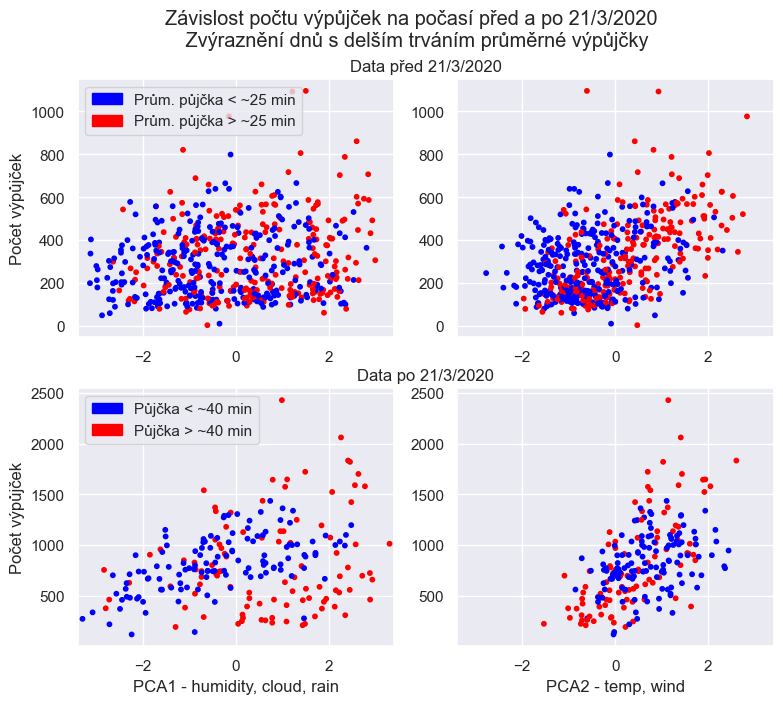

In [37]:
# rozdělení skupin v grafu na dny s podprůměrnou a nadprůměrnou dobou trvání výpůjčky
avg_duration_limits = [graph_columns_df[0]["average_duration"].mean(),graph_columns_df[1]["average_duration"].mean()]
fig, all_ax = plt.subplots(2,2,figsize=(8,7))
for i, row in enumerate(all_ax):
    for j,ax in enumerate(row):
        z=graph_columns_df[i]
        if i==1: ax.set_xlabel(pca_names[j]+pca_names2[j])
        if j==0: ax.set_ylabel("Počet výpůjček")
        ax.set_xlim([pca_min[0],pca_max[0]])
        ax.scatter(z[pca_names[j]], z['count'], c=pd.Series(np.where(z["average_duration"]<avg_duration_limits[i], 0, 1)).map(colors), s=10, alpha=1)

date_before0 = mpatches.Patch(color=colors[0], label='Prům. půjčka < ~25 min')
date_before1 = mpatches.Patch(color=colors[1], label='Prům. půjčka > ~25 min')
date_after0 = mpatches.Patch(color=colors[0], label='Půjčka < ~40 min')
date_after1 = mpatches.Patch(color=colors[1], label='Půjčka > ~40 min')
all_ax[0][0].legend(handles=[date_before0,date_before1],loc="upper left")
all_ax[1][0].legend(handles=[date_after0,date_after1],loc="upper left")
plt.suptitle("Závislost počtu výpůjček na počasí před a po 21/3/2020 \n Zvýraznění dnů s delším trváním průměrné výpůjčky")
all_ax[0][0].set_title('Data před 21/3/2020',x=1.1)
all_ax[1][0].set_title('Data po 21/3/2020',x=1.1);

print(f"Průměrná délka výpůjčky před a po 21/3/2020: {round(graph_columns_df[0]['average_duration'].mean(),1)} a {round(graph_columns_df[1]['average_duration'].mean(),1)} minut")

#### Jiný způsob zobrazení vlivu počasí na počet výpůjček pro PCA1 a PCA2 u dat po 21/3/2020 rozdělených podle nadprůměrných a podprůměrných dob trvání půjčky:
<b>Data seřazená v heatmapě podle PCA hodnot, barevně je vidět buď postupné zvyšování počtu půjček anebo různě rozmístěné počty půjček, kde je znát jen menší trend u půjček s nejvyššími hodnotami PCA

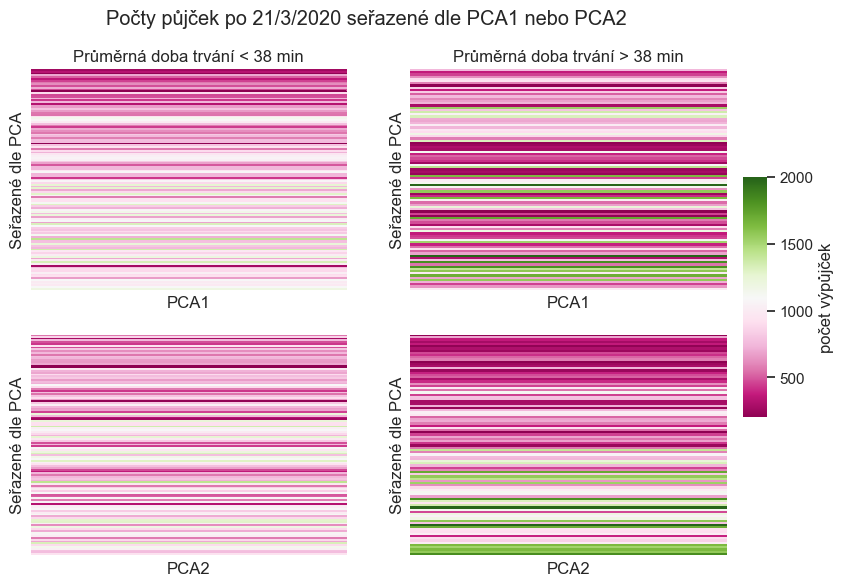

In [39]:
# heatmapy po 21/3/2020 PCA2 s podrůměrnou a nadprůměrnou dobou trvání
z1= w[w.index > '2020-03-21'].query("average_duration < 38").sort_values(by=["PCA1"])
z2= w[w.index > '2020-03-21'].query("average_duration > 38").sort_values(by=["PCA1"])
z3= w[w.index > '2020-03-21'].query("average_duration < 38").sort_values(by=["PCA2"])
z4= w[w.index > '2020-03-21'].query("average_duration > 38").sort_values(by=["PCA2"])
z_all = [z1,z2,z3,z4]

fig, axs = plt.subplots(2,2,figsize=(8,6))
cbar_ax = fig.add_axes([0.97, .3, .03, .4])

plt.ylabel("Sorted PCA values")

for i, ax in enumerate(axs.reshape(-1)): 
    sns.heatmap(z_all[i][["count"]],ax=ax,cmap="PiYG",  yticklabels=False,xticklabels=False, cbar= i==0, cbar_ax=None if i else cbar_ax, vmin=200,vmax=2000, cbar_kws={'label': 'počet výpůjček'} )
    ax.set_ylabel("Seřazené dle PCA")
axs[0][0].set(title="Průměrná doba trvání < 38 min",xlabel="PCA1")
axs[0][1].set(title="Průměrná doba trvání > 38 min", xlabel="PCA1")
axs[1][0].set(xlabel="PCA2")
axs[1][1].set(xlabel="PCA2")
plt.suptitle("Počty půjček po 21/3/2020 seřazené dle PCA1 nebo PCA2");
#sns.heatmap(z2[["count"]],ax=ax2,cmap="PiYG",  yticklabels=False, cbar=True, vmin=200,vmax=2000, cbar_kws={'label': 'počet výpůjček'} )
